### Load Packages and Functions

In [18]:
import yt
from helper_functions import ss_properties, extract_simulation_name, setup_plot_env, eddington_rate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.cosmology import FlatLambdaCDM, z_at_value
import astropy.units as u
from yt.units import kboltz, mp

from yt.fields.field_detector import FieldDetector
from yt.utilities.physical_constants import c

from yt.units import Msun, yr, pc
from scipy.constants import m_p as m_h  # Proton mass in kg

# Define the cosmology with the given parameters
cosmo = FlatLambdaCDM(H0=71 * u.km / u.s / u.Mpc, Om0=0.266, Ob0=0.0449)

# Initial redshift
z_initial = 19.23 # h1 at z=26.31, h2 at z=19.23

# Convert 2.5 Myr to the correct units
delta_t = 0.5 * u.Myr

# Look at the time corresponding to the initial redshift
t_initial = cosmo.lookback_time(z_initial)

# Add the 2.5 Myr to the time
t_new = t_initial - delta_t

# Compute the new redshift after 2.5 Myr using inverse lookback time
z_new = z_at_value(cosmo.lookback_time, t_new)

# Output the result
print(f"New redshift after 2.5 Myr: z = {z_new:.2f}")


New redshift after 2.5 Myr: z = 19.20 redshift


In [19]:
# Calculate Specific Heating Rate

def _bh_specific_heating_rate(field, data):
    field_data = data.ds.arr(np.zeros(data["gas", "density"].shape), "erg/s/g")
    if isinstance(data, FieldDetector):
        return field_data

    # get all black holes in this data object
    cell_pos = data.ds.arr([data["index", ax] for ax in "xyz"]).T
    bh_pos = data.get_field_parameter("bh_centers")
    bh_r = data.get_field_parameter("bh_feedback_radii")
    mdot = data.get_field_parameter("accretion_rate")
    epsilon = data.get_field_parameter("epsilon")
    print(f"bh_pos: {bh_pos}, bh_r: {bh_r}, mdot: {mdot}")

    # loop over each bh and add heating where d < r
    for i in range(bh_r.size):
        my_pos = bh_pos[i]
        my_r2 = bh_r[i]**2
        d2 = ((cell_pos - my_pos)**2).sum(axis=1)
        my_mdot = mdot[i]
        my_filter = d2 <= my_r2
        field_data[my_filter] = epsilon * c**2 * my_mdot / \
          data["gas", "cell_mass"] / my_filter.sum()
        # total_mass_in_region = data["gas", "cell_mass"][my_filter].sum()
        # field_data[my_filter] = epsilon * c**2 * my_mdot / data["gas", "cell_mass"] * (data["gas", "cell_mass"] / total_mass_in_region)

    return field_data

yt.add_field(("gas", "BH_specific_heating_rate"),
             _bh_specific_heating_rate,
             sampling_type="local",
             units="erg/s/g")

def _bh_accretion_cooling_time(field, data):
    # assume here that cooling is positive
    edot = data["gas", "specific_thermal_energy"] / data["gas", "cooling_time"]
    edot_bh = data["gas", "BH_specific_heating_rate"]
    edot_net = edot - edot_bh
    return data["gas", "specific_thermal_energy"] / edot_net

yt.add_field(("gas", "BH_accretion_cooling_time"),
             _bh_accretion_cooling_time,
             sampling_type="local",
             units="s")

def _bh_accretion_heating_to_cooling_ratio(field, data):
    edot = data["gas", "specific_thermal_energy"] / data["gas", "cooling_time"]
    edot_bh = data["gas", "BH_specific_heating_rate"]
    return edot_bh / edot

yt.add_field(("gas", "BH_accretion_heating_to_cooling_ratio"),
             _bh_accretion_heating_to_cooling_ratio,
             sampling_type="local", units="")

def bh_prepare_object(data, epsilon=None):
    spos = data["SmartStar", "particle_position"]
    sdx = data.ds.find_field_values_at_points([("index", "dx")], spos)
    try:
        r_cells = ds.parameters['SmartStarBHThermalFeedbackRadiusinCells']
        if r_cells == 0:
            r_cells = 5
    except KeyError:
        r_cells = 5
    data.set_field_parameter("bh_centers", spos)
    data.set_field_parameter("bh_feedback_radii", r_cells * sdx)
    data.set_field_parameter("epsilon", epsilon)
    mdot_now = data["SmartStar", "AccretionRate"][:, -1]
    data.set_field_parameter("accretion_rate", mdot_now)

## Calculate the ratio of cooling time / sound speed to identify potential overcooling in simulation
This is from Vecchia + Schaye 2012 (Simulating galactic outflows with thermal supernova feedback). 
To identify overcooling, the paper proposes criteria based on the ratio of radiative cooling time (tc) to the sound-crossing time (ts​). When tc/ts > 8-10, feedback can overcome radiative losses, allowing the gas to expand adiabatically and convert thermal to kinetic energy. This was applied to supernova thermal feedback.

Their threshold of tc/ts > 8-10 may be too high for my simulations. Their gas particles at a minimum were 500 msun smoothed over 10 pc. My simulations are sub-pc scale.

The ratio of cooling time to sound-crossing time, \($\frac{t_c}{t_s}$\), indicates the relative importance of radiative cooling versus adiabatic expansion (or compression). The key interpretations are:

1. \( $\frac{t_c}{t_s} \gg 1$ \): Cooling is inefficient compared to the gas dynamics. In this regime, gas can expand and convert thermal energy into kinetic energy before losing much of it to radiation. This is desirable for effective feedback, such as when heating gas via supernovae or black hole feedback. The injected energy drives gas outflows, reduces star formation, and influences the structure of the interstellar medium (ISM).
    
2. \( $\frac{t_c}{t_s} \ll 1$ \): Cooling is very efficient, meaning the gas loses thermal energy rapidly before it can respond dynamically. In this regime, any heating from feedback (e.g., supernovae or black hole jets) is quickly radiated away, leading to poor coupling of feedback energy with the gas. This can result in the "overcooling problem" in simulations, where the gas collapses and forms stars too efficiently, and feedback fails to generate large-scale outflows.
    
3. \($ \frac{t_c}{t_s} \approx 1 $ \): Cooling and adiabatic processes are comparable. The gas may begin to cool before significant expansion occurs, but not so rapidly that feedback is entirely ineffective. This intermediate regime is often where fine-tuning feedback models becomes important in simulations.



In [5]:
def calculate_tc_ts_ratio(dataset, width=(10, "pc"), orientation="x", title=None):
    # Load the dataset
    ds = yt.load(dataset)
    sim = extract_simulation_name(dataset)
    ss_pos, ss_mass, _  = ss_properties(ds)
    
    # Check if the necessary fields are available
    if not all([("gas", "cooling_time"), ("gas", "sound_speed")]):
        print("The dataset does not have the required fields for cooling time or sound speed.")
        return
    
    # Define a new field for the tc/ts ratio
    def _tc_ts_ratio(field, data):
        # Use yt's built-in fields for cooling time and sound speed
        tc = data["gas", "cooling_time"]
        h = data["index", "dx"]  # Characteristic length scale (cell size)
        cs = data["gas", "sound_speed"]
        ts = h / cs
        return tc / ts

    # Add the tc/ts ratio field to the dataset
    ds.add_field(("gas", "tc_ts_ratio"), function=_tc_ts_ratio, 
                 units="", sampling_type="cell", display_name="Cooling Time / Sound Crossing Time")

    # Create a slice plot of the tc/ts ratio
    plot = yt.SlicePlot(ds, orientation, ("gas", "tc_ts_ratio"), center=ss_pos, width=width)
    plot.set_cmap(("gas", "tc_ts_ratio"), "coolwarm")
    plot.set_log(("gas", "tc_ts_ratio"), True)
    plot.set_zlim(("gas", "tc_ts_ratio"), 1e-1, 1e4)
    plot.set_axes_unit("pc")
    plot.annotate_title(f"{title} ({ss_mass:.2e})") if title else None
    plot.show()

    # Create a slice plot of the tc/ts ratio
    plot = yt.SlicePlot(ds, orientation, ("gas", "number_density"), center=ss_pos, width=width)
    plot.set_log(("gas", "number_density"), True)
    plot.set_cmap(("gas", "number_density"), "viridis")
    #plot.set_zlim(("gas", "number_density"), 8, 1e4)
    plot.set_axes_unit("pc")
    plot.show()

### Event 2
60,000 msun BH

yt : [INFO     ] 2024-10-11 17:19:29,224 Parameters: current_time              = 17.497413206594
yt : [INFO     ] 2024-10-11 17:19:29,226 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-11 17:19:29,228 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-11 17:19:29,229 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-11 17:19:29,231 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-11 17:19:29,232 Parameters: current_redshift          = 22.459988284746
yt : [INFO     ] 2024-10-11 17:19:29,234 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-11 17:19:29,235 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-11 17:19:29,236 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-11 17:19:29,237 Parameters: hubble_constant           = 0.71


ds =  DD2783


Parsing Hierarchy : 100%|██████████| 3838/3838 [00:00<00:00, 10030.48it/s]
yt : [INFO     ] 2024-10-11 17:19:29,731 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2024-10-11 17:19:32,490 xlim = 0.492842 0.492909
yt : [INFO     ] 2024-10-11 17:19:32,492 ylim = 0.508225 0.508292
yt : [INFO     ] 2024-10-11 17:19:32,495 xlim = 0.492842 0.492909
yt : [INFO     ] 2024-10-11 17:19:32,497 ylim = 0.508225 0.508292
yt : [INFO     ] 2024-10-11 17:19:32,502 Making a fixed resolution buffer of (('gas', 'tc_ts_ratio')) 800 by 800



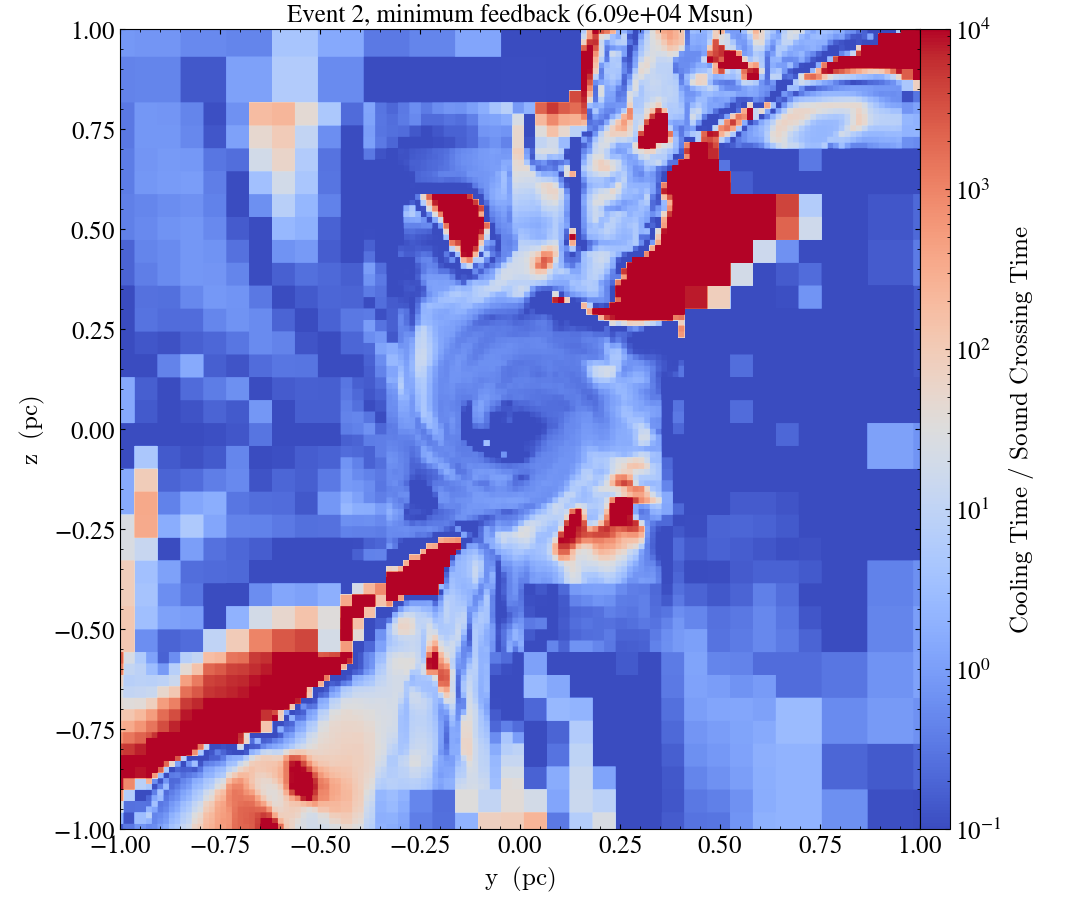

yt : [INFO     ] 2024-10-11 17:19:34,037 xlim = 0.492842 0.492909
yt : [INFO     ] 2024-10-11 17:19:34,038 ylim = 0.508225 0.508292
yt : [INFO     ] 2024-10-11 17:19:34,042 xlim = 0.492842 0.492909
yt : [INFO     ] 2024-10-11 17:19:34,043 ylim = 0.508225 0.508292
yt : [INFO     ] 2024-10-11 17:19:34,045 Making a fixed resolution buffer of (('gas', 'number_density')) 800 by 800



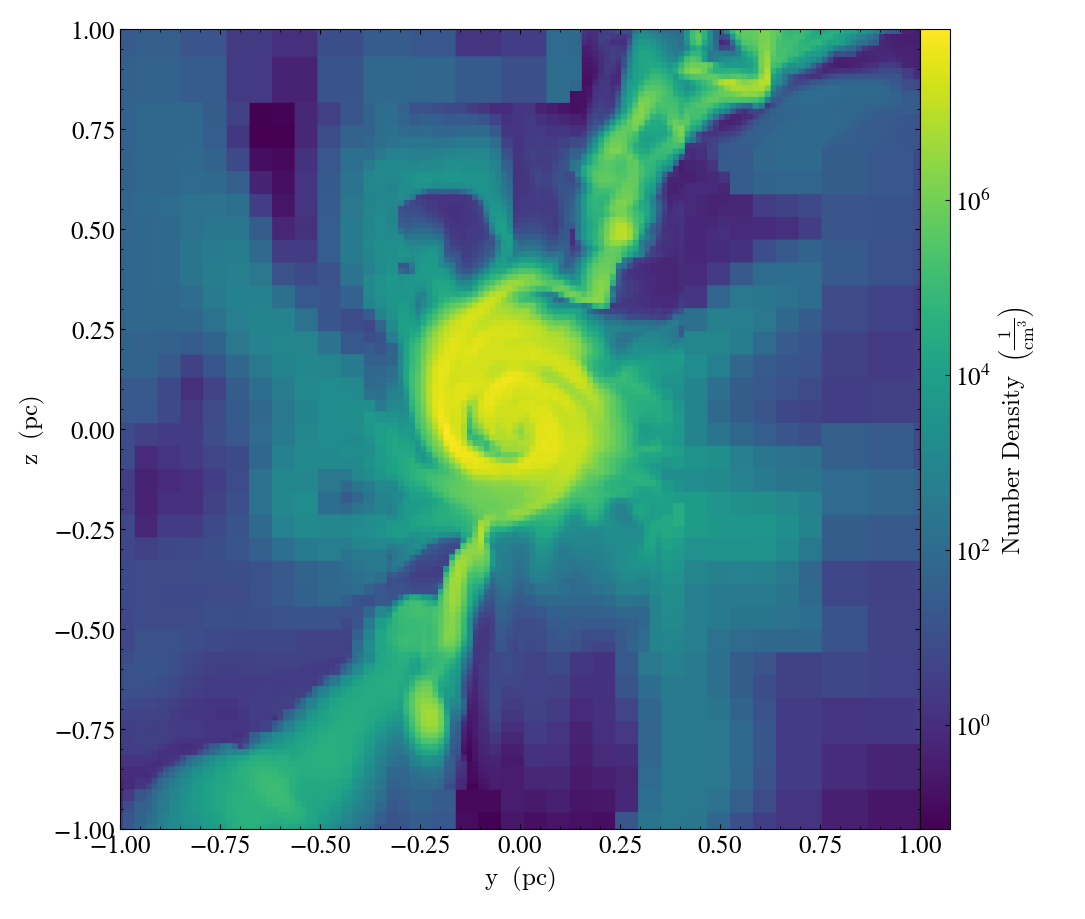

In [3]:
# Event 2, minimum feedback
fp = "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b01-3-eps-0.001/DD2783/DD2783"
calculate_tc_ts_ratio(fp, width=(2, "pc"), orientation="x", title= "Event 2, minimum feedback")

yt : [INFO     ] 2024-10-11 08:15:19,553 Parameters: current_time              = 17.497046862082
yt : [INFO     ] 2024-10-11 08:15:19,554 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-11 08:15:19,555 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-11 08:15:19,556 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-11 08:15:19,557 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-11 08:15:19,558 Parameters: current_redshift          = 22.460315768987
yt : [INFO     ] 2024-10-11 08:15:19,559 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-11 08:15:19,559 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-11 08:15:19,560 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-11 08:15:19,561 Parameters: hubble_constant           = 0.71


ds =  DD0641


Parsing Hierarchy : 100%|██████████| 4531/4531 [00:00<00:00, 10768.29it/s]
yt : [INFO     ] 2024-10-11 08:15:20,067 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2024-10-11 08:15:22,899 xlim = 0.492842 0.492909
yt : [INFO     ] 2024-10-11 08:15:22,900 ylim = 0.508225 0.508291
yt : [INFO     ] 2024-10-11 08:15:22,903 xlim = 0.492842 0.492909
yt : [INFO     ] 2024-10-11 08:15:22,904 ylim = 0.508225 0.508291
yt : [INFO     ] 2024-10-11 08:15:22,905 Making a fixed resolution buffer of (('gas', 'tc_ts_ratio')) 800 by 800



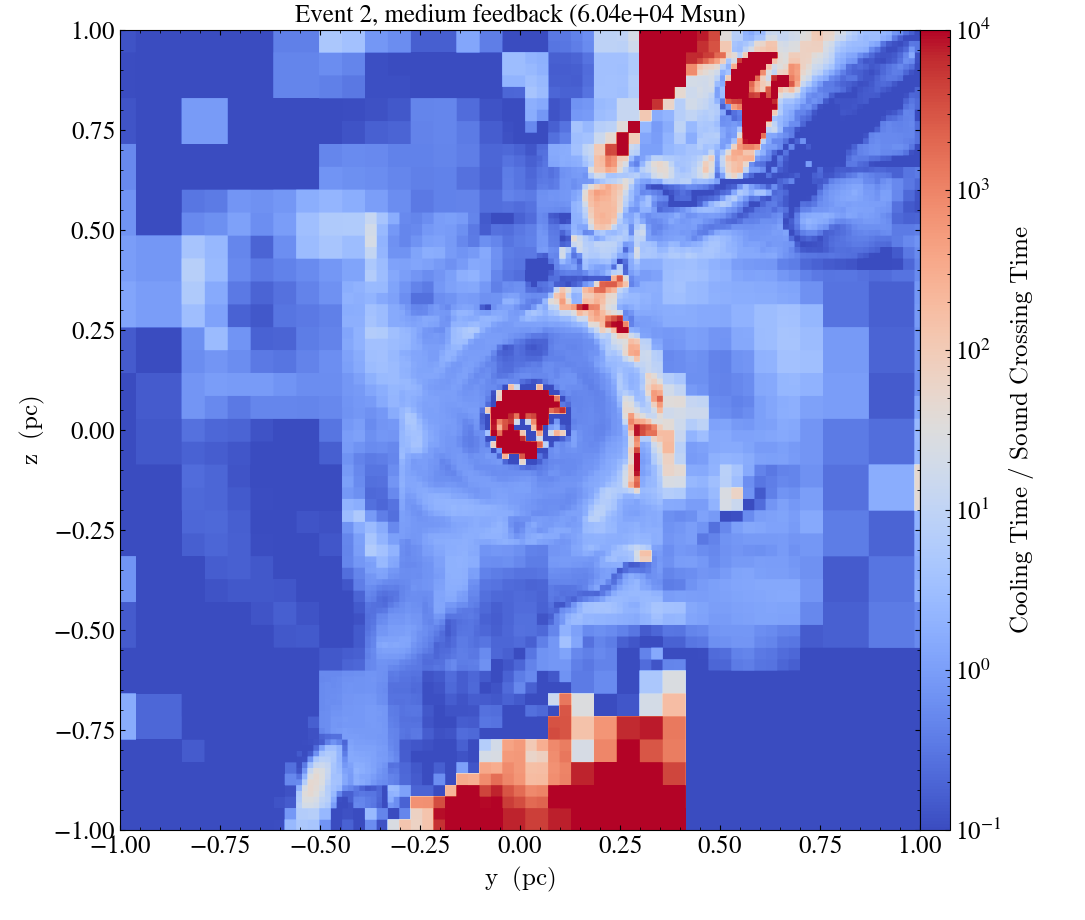

yt : [INFO     ] 2024-10-11 08:15:23,693 xlim = 0.492842 0.492909
yt : [INFO     ] 2024-10-11 08:15:23,694 ylim = 0.508225 0.508291
yt : [INFO     ] 2024-10-11 08:15:23,696 xlim = 0.492842 0.492909
yt : [INFO     ] 2024-10-11 08:15:23,697 ylim = 0.508225 0.508291
yt : [INFO     ] 2024-10-11 08:15:23,699 Making a fixed resolution buffer of (('gas', 'number_density')) 800 by 800



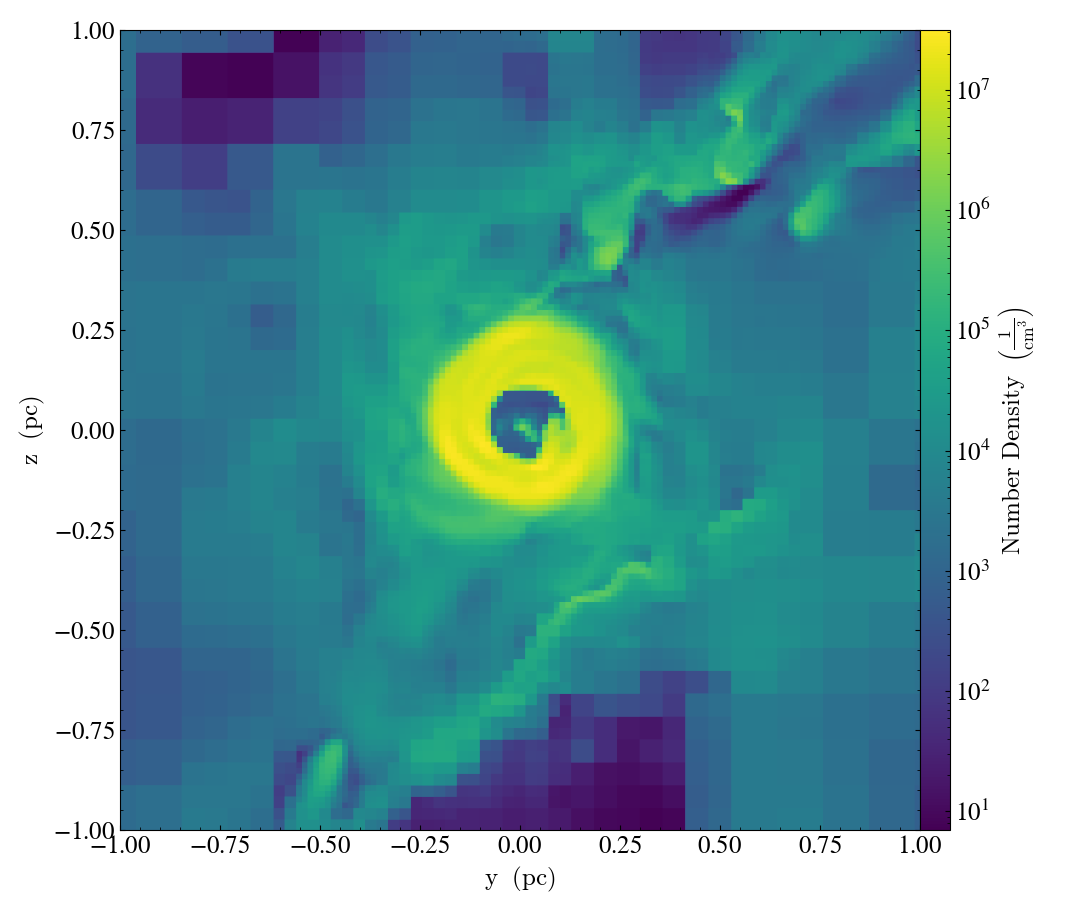

In [58]:
# Event 2, medium feedback
fp = "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b01-3-eta-0.01/DD0641/DD0641"
calculate_tc_ts_ratio(fp, width=(2, "pc"), orientation="x", title= "Event 2, medium feedback")

yt : [INFO     ] 2024-10-11 08:16:03,477 Parameters: current_time              = 17.497448947522
yt : [INFO     ] 2024-10-11 08:16:03,478 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-11 08:16:03,480 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-11 08:16:03,482 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-11 08:16:03,484 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-11 08:16:03,485 Parameters: current_redshift          = 22.459956335676
yt : [INFO     ] 2024-10-11 08:16:03,486 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-11 08:16:03,488 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-11 08:16:03,489 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-11 08:16:03,490 Parameters: hubble_constant           = 0.71


ds =  DD0695


Parsing Hierarchy : 100%|██████████| 5465/5465 [00:01<00:00, 5275.30it/s]
yt : [INFO     ] 2024-10-11 08:16:04,690 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2024-10-11 08:16:39,121 xlim = 0.492843 0.492909
yt : [INFO     ] 2024-10-11 08:16:39,123 ylim = 0.508224 0.508290
yt : [INFO     ] 2024-10-11 08:16:39,131 xlim = 0.492843 0.492909
yt : [INFO     ] 2024-10-11 08:16:39,133 ylim = 0.508224 0.508290
yt : [INFO     ] 2024-10-11 08:16:39,138 Making a fixed resolution buffer of (('gas', 'tc_ts_ratio')) 800 by 800



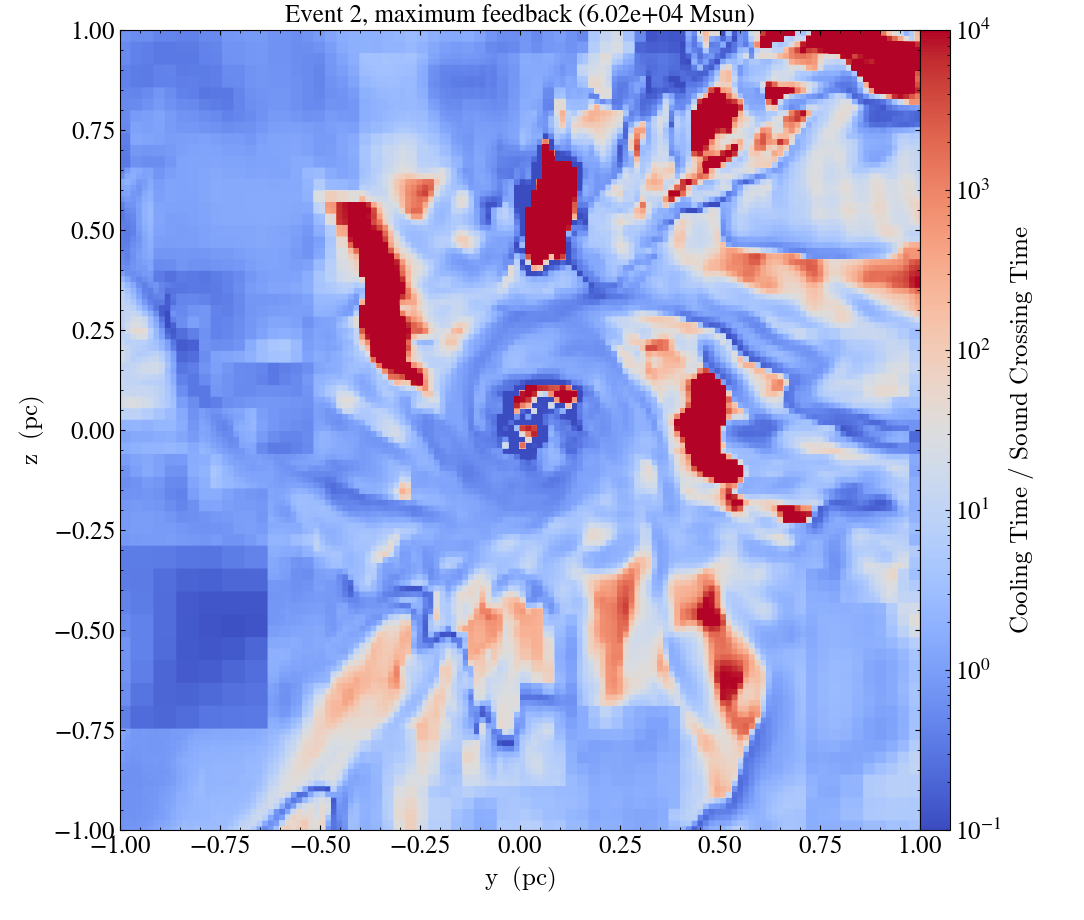

yt : [INFO     ] 2024-10-11 08:16:52,772 xlim = 0.492843 0.492909
yt : [INFO     ] 2024-10-11 08:16:52,773 ylim = 0.508224 0.508290
yt : [INFO     ] 2024-10-11 08:16:52,779 xlim = 0.492843 0.492909
yt : [INFO     ] 2024-10-11 08:16:52,781 ylim = 0.508224 0.508290
yt : [INFO     ] 2024-10-11 08:16:52,784 Making a fixed resolution buffer of (('gas', 'number_density')) 800 by 800



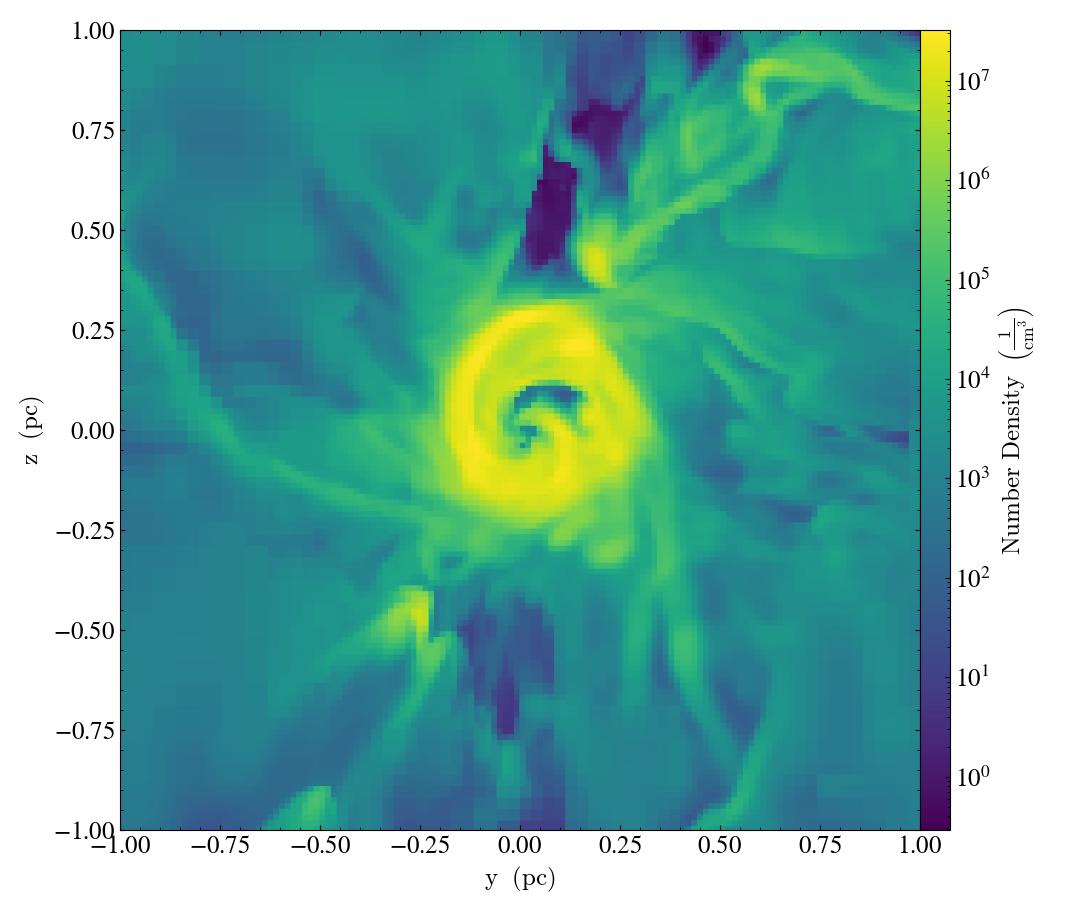

In [59]:
# Event 2, maximum feedback
fp = "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b01-3-eta-0.1/DD0695/DD0695"
calculate_tc_ts_ratio(fp, width=(2, "pc"), orientation="x", title= "Event 2, maximum feedback")

### Event 1

In [27]:
# Event 1: initial state at 2.50 Myr, take fb values at 2.70 Myr
# simulations_1 = [
#     {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04/DD0153/DD0153", "name": "Initial State"},
#     {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04-eps-0.001/DD0352/DD0352", "name": "Min Feedback: eps-0.001"},
#     {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04-eta-0.1/DD0352/DD0352", "name": "Max Feedback 1: eta-0.1-fbr-5dx"},
#     {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04-eta-0.1/fb-r-7dx/DD0352/DD0352", "name": "Max Feedback 2: eta-0.1-fbr-7dx"},
#     {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04-eta-0.1/fb-r-10dx/DD0352/DD0352", "name": "Max Feedback 3: eta-0.1-fbr-10dx"},
# ]

# for sim in simulations_1:
#     calculate_tc_ts_ratio(sim["path"], width=(1, "pc"), orientation="x", title = sim["name"])
#     print(sim["name"])

### Event 3

In [28]:

# # Event 3: initial state at 6.5 Myr, take fb values at 6.7 Myr
# simulations_3 = [
#     {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed2-bh-only/270msun/thermal-fb/2B.resim.th.b01-eps-0.001/DD0263/DD0263", "name": "Initial State"},
#     #{"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed2-bh-only/270msun/thermal-fb/2B.resim.th.b01-eps-0.001/DD1314/DD1314", "name": "Min Feedback"}, # bad data, rerunning
#     {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed2-bh-only/270msun/thermal-fb/2B.resim.th.b01-eps-0.01/DD0511/DD0511", "name": "Mid Feedback: eps-0.01"},
#     {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed2-bh-only/270msun/thermal-fb/2B.resim.th.b01/DD0900/DD0900", "name": "Max Feedback 1: eta-0.1-fbr-5dx"},
#     {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed2-bh-only/270msun/thermal-fb/2B.resim.th.b01/2B.resim.th.b01-fb-r-7dx/DD0600/DD0600", "name": "Max Feedback 2: eta-0.1-fbr-7dx"},
# ]

# for sim in simulations_3:
#     print(sim["name"])
#     calculate_tc_ts_ratio(sim["path"], width=(1, "pc"), orientation="x", title = sim["name"])

# Heating time
Calculate the time it takes to heat the gas from accretion processes where heating_time = thermal_energy/heating_rate, where
- thermal_energy = (3/2) * (density / mean_molecular_weight) * k_B * T * volume
- heating_rate = epsilon * bh_accretion_rate * c**2  # in erg/s

net_thermal_change_time = heating_time - cooling_time.

-> Negative net means that cooling_time >> heating_time -> heating is the dominant process

In [7]:
# Load the dataset
ds = yt.load("/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04-eta-0.1/DD0352/DD0352")
cell_width = ds.index.get_smallest_dx().to('cm')  # Gets the smallest cell width in the dataset
epsilon = 0.1 * 0.05 # Define epsilon (feedback efficiency)
radius = 5 * cell_width  # Radius of the sphere

# Define the position of the black hole (in code units)
ss_pos, ss_mass, ss_age = ss_properties(ds)
print(f"Black hole age: {ss_age[0]/1e6:.2f} Myr")

# Create a sphere centered at the black hole position with the defined radius
sphere = ds.sphere(ss_pos, radius)

# Calculate the accretion rate
ad = ds.all_data()
bh_accretion_rate = ad[("SmartStar", "AccretionRate")][0].in_units("g/s")
bh_accretion_rate.to("Msun/yr")

# Calculate the total thermal energy in the sphere
# Thermal energy = (3/2) * (density / mean_molecular_weight) * k_B * T * volume

mean_molecular_weight = 0.6  # Assume a mean molecular weight for fully ionized gas
sphere_volume = (4/3) * np.pi * radius**3
thermal_energy = (1.5 * sphere["gas", "density"] / (mean_molecular_weight * mp) *
                  kboltz * sphere["gas", "temperature"] * cell_width**3).sum().in_units("erg")

# Calculate the energy injection rate (feedback rate)
c = 3.0e10 * yt.units.cm/yt.units.s  # Speed of light in cm/s
heating_rate = epsilon * bh_accretion_rate * c**2  # in erg/s

# Calculate the heating time - cooling time
heating_time = (thermal_energy / heating_rate).in_units("s")

# Output the result
print(f"The heating time for the sphere is {heating_time}.")
print(f"The average heating time accross the whole sphere is {(thermal_energy/np.mean(heating_rate)).in_units('yr'):.5f}")

yt : [INFO     ] 2024-10-21 09:43:46,357 Parameters: current_time              = 14.236022253282
yt : [INFO     ] 2024-10-21 09:43:46,359 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-21 09:43:46,361 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-21 09:43:46,362 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-21 09:43:46,364 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-21 09:43:46,365 Parameters: current_redshift          = 25.918740127656
yt : [INFO     ] 2024-10-21 09:43:46,366 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-21 09:43:46,367 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-21 09:43:46,368 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-21 09:43:46,369 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 2794/2794 [00:00<00:00, 7834.29it/s] 
yt : [INFO     ] 2024-10-2

ds =  DD0352
Black hole age: 2.70 Myr
The heating time for the sphere is [1736.02296975 1017.00008829 1302.1611636  ... 1817.33130618 2003.69483471
 2367.43953505] s.
The average heating time accross the whole sphere is 0.00007 yr


/home/sgordon/micromamba/lib/python3.9/site-packages/unyt/array.py:1949: RuntimeWarning: divide by zero encountered in divide
  out_arr = func(


In [8]:
net_thermal_change_time = (thermal_energy / np.mean(heating_rate)).in_units("Myr") - sphere["gas", "cooling_time"].mean().in_units("Myr")
net_thermal_change_time

unyt_quantity(-0.64283029, 'Myr')


##### Average heating time across the accretion sphere:
Event 1
- 0.00007 yr for 1B.resim.th.b04-eta-0.1/DD0352/DD0352 at 2.70 Myr
- 0.00010 yr for 1B.resim.th.b04-eta-0.1/fb-r-7dx/DD0352/DD0352 at 2.70 Myr (r = 7dx)
- 0.00803 yr for 1B.resim.th.b04-eta-0.1/fb-r-10dx/DD0352/DD0352 at 2.70 Myr (r = 10dx)
- 0.01773 yr 1B.resim.th.b04-eta-0.01-2/DD0307/DD0307 at 2.72 Myr (epsilon = 0.01 * 0.05)
- 0.77945 yr for 1B.resim.th.b04-eps-0.001/DD0352/DD0352 at 2.70 Myr (epsilon = 0.001 * 0.01)


Net thermal change time 
- -0.09182458, 'Myr' for 1B.resim.th.b04-eps-0.001/DD0352/DD0352 at 2.70 Myr 
- -0.64283029, 'Myr' for 1B.resim.th.b04-eta-0.1/DD0352/DD0352 at 2.70 Myr

# Mass inflow through 2D spherical shell

In [10]:
def mass_inflow_rate(ds, center, radius, thickness):
    """
    Calculate the mass inflow rate through a 2D spherical shell at a given radius.
    
    Parameters:
    ds : yt dataset
        The simulation dataset.
    center : array-like
        The center of the spherical shell (typically the position of a black hole or galaxy center).
    radius : float
        The radius of the spherical shell (in code units or specify the unit).
    thickness : float
        The thickness of the shell to approximate the 2D surface.
    
    Returns:
    inflow_rate : float
        The mass inflow rate (in units of mass per time).
    """

    # Create a spherical shell with a small thickness
    shell = ds.sphere(center, radius + thickness) - ds.sphere(center, radius)

    # Get the gas density and radial velocity fields
    density = shell[("gas", "density")]  # in units of g/cm^3 or equivalent
    radial_velocity = shell[("gas", "radial_velocity")].in_units("cm/s")  # positive outward, negative inward
    
    # Select only inward flowing gas (radial_velocity < 0 for inflow)
    inflow_mask = radial_velocity < 0
    inflowing_density = density[inflow_mask]
    inflowing_radial_velocity = radial_velocity[inflow_mask]
    
    # Calculate mass flux: density * velocity * shell volume (cell area)
    cell_areas = shell["cell_area"][inflow_mask]  # Area of each cell in cm^2
    
    # Mass inflow rate is the sum of inflowing mass flux through the shell
    mass_flux = inflowing_density * inflowing_radial_velocity * cell_areas  # in g/s
    
    # Sum the mass flux to get the total inflow rate
    inflow_rate = np.sum(mass_flux)
    
    return inflow_rate


In [11]:
# inflow_rate = mass_inflow_rate(ds, center, radius, thickness)
# print(f"Mass inflow rate: {inflow_rate:.3e} g/s")
# m_h = 1.6735575e-24 * yt.units.g  # Mass of a hydrogen atom
# m_h

In [12]:
# Calculate the mass inflow rate at through a sphere of certain radius
ds = yt.load("/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04-eps-0.001/DD0352/DD0352")
center = ss_pos  # Center of the sphere, change to match your center
radius = .5*yt.units.pc # Radius of the shell in code units
thickness = ds.index.get_smallest_dx().in_units("pc")  # Small thickness for the spherical shell

# Create a spherical shell with a small thickness
shell = ds.sphere(center, radius + thickness) - ds.sphere(center, radius)

# Get the gas density and radial velocity fields
density = shell[("gas", "density")]  # in units of g/cm^3 or equivalent
radial_velocity = shell[("gas", "radial_velocity")].in_units("cm/s")  # positive outward, negative inward

# Select only inward flowing gas (radial_velocity < 0 for inflow)
inflow_mask = radial_velocity < 0
inflowing_density = density[inflow_mask]
inflowing_radial_velocity = radial_velocity[inflow_mask]

print(f"Sphere radius = {radius:.2f}, Sphere thickness = {thickness:.2e}, cell width = {ds.index.get_smallest_dx().in_units('pc'):.2e}")
print(f"Inflowing Mean Density = {np.mean(inflowing_density/m_h):.2e}, Inflowing Mean radial velocity = {np.mean(inflowing_radial_velocity.to('km/s')):.2e}")

# Get cell volumes and calculate approximate cross-sectional area for the spherical shell
cell_volumes = shell["index", "cell_volume"].in_units("cm**3")  # Volume of each cell in cm^3
cell_radii = shell["index", "dx"].in_units("cm")[inflow_mask]  # Radial distance of each cell
cell_areas = (cell_volumes[inflow_mask] / cell_radii)

# Mass inflow rate is the sum of inflowing mass flux through the shell
mass_flux = inflowing_density * inflowing_radial_velocity * cell_areas # in g/s

# Sum the mass flux to get the total inflow rate
inflow_rate = np.sum(mass_flux)
inflow_rate.to("Msun/yr")


yt : [INFO     ] 2024-10-21 09:47:25,763 Parameters: current_time              = 14.236022253282
yt : [INFO     ] 2024-10-21 09:47:25,765 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-21 09:47:25,767 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-21 09:47:25,768 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-21 09:47:25,770 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-21 09:47:25,771 Parameters: current_redshift          = 25.918740127656
yt : [INFO     ] 2024-10-21 09:47:25,773 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-21 09:47:25,774 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-21 09:47:25,776 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-21 09:47:25,777 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 2750/2750 [00:00<00:00, 14321.22it/s]
yt : [INFO     ] 2024-10-2

Sphere radius = 0.50 pc, Sphere thickness = 3.12e-03 pc, cell width = 3.12e-03 pc
Inflowing Mean Density = 6.17e+08 g/cm**3, Inflowing Mean radial velocity = -5.48e+01 km/s


unyt_quantity(-0.00181587, 'Msun/yr')

yt : [INFO     ] 2024-10-21 09:48:02,427 Parameters: current_time              = 14.236022253282
yt : [INFO     ] 2024-10-21 09:48:02,429 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-21 09:48:02,430 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-21 09:48:02,432 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-21 09:48:02,433 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-21 09:48:02,435 Parameters: current_redshift          = 25.918740127656
yt : [INFO     ] 2024-10-21 09:48:02,436 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-21 09:48:02,438 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-21 09:48:02,439 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-21 09:48:02,440 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 2750/2750 [00:00<00:00, 16458.46it/s]
yt : [INFO     ] 2024-10-2

Radius = 0.01 pc, Mass inflow rate = -2.85e-03 Msun/yr
Radius = 0.01 pc, Mass inflow rate = -2.48e-02 Msun/yr
Radius = 0.02 pc, Mass inflow rate = -5.19e-02 Msun/yr
Radius = 0.03 pc, Mass inflow rate = -5.75e-02 Msun/yr
Radius = 0.04 pc, Mass inflow rate = -6.57e-02 Msun/yr
Radius = 0.05 pc, Mass inflow rate = -3.31e-02 Msun/yr
Radius = 0.06 pc, Mass inflow rate = -2.27e-02 Msun/yr
Radius = 0.07 pc, Mass inflow rate = -1.45e-02 Msun/yr
Radius = 0.08 pc, Mass inflow rate = -9.67e-03 Msun/yr
Radius = 0.09 pc, Mass inflow rate = -6.42e-03 Msun/yr
Radius = 0.10 pc, Mass inflow rate = -6.10e-03 Msun/yr
Radius = 0.11 pc, Mass inflow rate = -6.15e-03 Msun/yr
Radius = 0.12 pc, Mass inflow rate = -6.18e-03 Msun/yr
Radius = 0.13 pc, Mass inflow rate = -7.06e-03 Msun/yr
Radius = 0.14 pc, Mass inflow rate = -1.06e-02 Msun/yr
Radius = 0.15 pc, Mass inflow rate = -1.23e-02 Msun/yr
Radius = 0.16 pc, Mass inflow rate = -1.62e-02 Msun/yr
Radius = 0.17 pc, Mass inflow rate = -1.17e-02 Msun/yr
Radius = 0

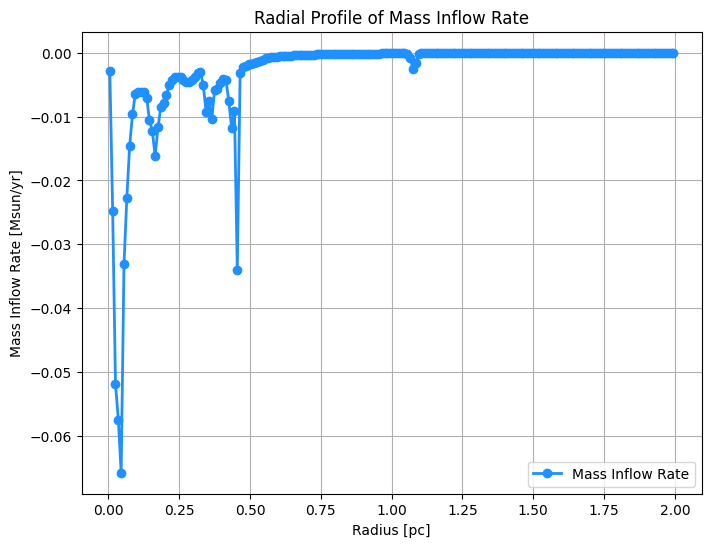

In [13]:

def calculate_mass_inflow_rate(ds, center, radius, thickness):
    """
    Calculate the mass inflow rate through a spherical shell at a given radius.

    Parameters:
    ds : yt dataset
        The simulation dataset.
    center : array-like
        The center of the spherical shell (e.g., black hole position).
    radius : float
        The radius of the spherical shell (in pc).
    thickness : float
        The thickness of the shell to approximate the 2D surface (in pc).

    Returns:
    inflow_rate : yt.Quantity
        The mass inflow rate in solar masses per year (Msun/yr).
    """
    
    # Create a spherical shell with a small thickness
    shell = ds.sphere(center, radius + thickness) - ds.sphere(center, radius)

    # Get the gas density and radial velocity fields
    density = shell[("gas", "density")]  # in units of g/cm^3
    radial_velocity = shell[("gas", "radial_velocity")].in_units("cm/s")  # positive outward, negative inward

    # Select only inward flowing gas (radial_velocity < 0 for inflow)
    inflow_mask = radial_velocity < 0
    inflowing_density = density[inflow_mask]
    inflowing_radial_velocity = radial_velocity[inflow_mask]

    # Get cell volumes and calculate approximate cross-sectional area for the spherical shell
    cell_volumes = shell["index", "cell_volume"].in_units("cm**3")  # Volume of each cell in cm^3
    cell_radii = shell["index", "dx"].in_units("cm")[inflow_mask]  # Cell widths (dx) for area approximation
    cell_areas = (cell_volumes[inflow_mask] / cell_radii)

    # Mass inflow rate is the sum of inflowing mass flux through the shell
    mass_flux = inflowing_density * inflowing_radial_velocity * cell_areas  # in g/s

    # Sum the mass flux to get the total inflow rate
    inflow_rate = np.sum(mass_flux).to("Msun/yr")

    return inflow_rate

def plot_radial_inflow_profile(ds, center, min_radius=0, max_radius=2, step=0.02):
    """
    Plot the radial profile of mass inflow rate from 0 to 2 pc in steps of 0.02 pc.

    Parameters:
    ds : yt dataset
        The simulation dataset.
    center : array-like
        The center of the spherical shells (e.g., black hole position).
    min_radius : float
        The minimum radius to start calculating the inflow rate (in pc).
    max_radius : float
        The maximum radius to stop calculating the inflow rate (in pc).
    step : float
        The step size for the radial profile (in pc).
    """
    
    # Initialize arrays for radius and inflow rates
    radii = np.arange(min_radius, max_radius, step)*yt.units.pc
    inflow_rates = []

    # Get the smallest cell width to use as thickness
    thickness = ds.index.get_smallest_dx().in_units("pc")

    for r in radii:
        inflow_rate = calculate_mass_inflow_rate(ds, center, r, thickness)
        inflow_rates.append(inflow_rate)

        # Print out some useful information at each radius
        print(f"Radius = {r:.2f}, Mass inflow rate = {inflow_rate:.2e}")

    # Plotting the radial profile of mass inflow rate
    plt.figure(figsize=(8, 6))
    plt.plot(radii, inflow_rates, label="Mass Inflow Rate", color='dodgerblue', lw=2, marker='o')
    plt.xlabel("Radius [pc]")
    plt.ylabel("Mass Inflow Rate [Msun/yr]")
    plt.title("Radial Profile of Mass Inflow Rate")
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage:
ds = yt.load("/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04-eps-0.001/DD0352/DD0352")
center = ss_pos  # Set this to your black hole position or desired center

# Plot the radial profile of mass inflow rate
plot_radial_inflow_profile(ds, center, min_radius=0.005*yt.units.pc, max_radius=2*yt.units.pc, step=0.01*yt.units.pc)


# Bondi Rate though 2D spherical shell

yt : [INFO     ] 2024-10-25 08:49:59,512 Parameters: current_time              = 14.236022253282
yt : [INFO     ] 2024-10-25 08:49:59,513 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-25 08:49:59,515 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-25 08:49:59,516 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-25 08:49:59,519 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-25 08:49:59,519 Parameters: current_redshift          = 25.918740127656
yt : [INFO     ] 2024-10-25 08:49:59,520 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-25 08:49:59,522 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-25 08:49:59,524 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-25 08:49:59,524 Parameters: hubble_constant           = 0.71


ds =  DD0352


Parsing Hierarchy : 100%|██████████| 2794/2794 [00:00<00:00, 15793.24it/s]
yt : [INFO     ] 2024-10-25 08:49:59,771 Gathering a field list (this may take a moment.)


dx = 3.12e-03 pc
Radius = 0.02 pc, Bondi rate = 2.93e+02 dimensionless
dx = 6.24e-03 pc
Radius = 0.07 pc, Bondi rate = 1.39e+03 dimensionless
dx = 1.25e-02 pc
Radius = 0.12 pc, Bondi rate = 4.63e+02 dimensionless
dx = 1.25e-02 pc
Radius = 0.17 pc, Bondi rate = 5.29e+02 dimensionless
dx = 2.49e-02 pc
Radius = 0.22 pc, Bondi rate = 1.01e+03 dimensionless
dx = 2.49e-02 pc
Radius = 0.27 pc, Bondi rate = 1.52e+03 dimensionless
dx = 2.49e-02 pc
Radius = 0.32 pc, Bondi rate = 3.55e+03 dimensionless
dx = 4.99e-02 pc
Radius = 0.37 pc, Bondi rate = 4.36e+03 dimensionless
dx = 4.99e-02 pc
Radius = 0.42 pc, Bondi rate = 3.98e+03 dimensionless
dx = 4.99e-02 pc
Radius = 0.47 pc, Bondi rate = 7.07e+03 dimensionless
dx = 4.99e-02 pc
Radius = 0.52 pc, Bondi rate = 1.39e+04 dimensionless
dx = 4.99e-02 pc
Radius = 0.57 pc, Bondi rate = 1.63e+04 dimensionless
dx = 4.99e-02 pc
Radius = 0.62 pc, Bondi rate = 5.25e+03 dimensionless
dx = 4.99e-02 pc
Radius = 0.67 pc, Bondi rate = 1.85e+03 dimensionless
dx = 9

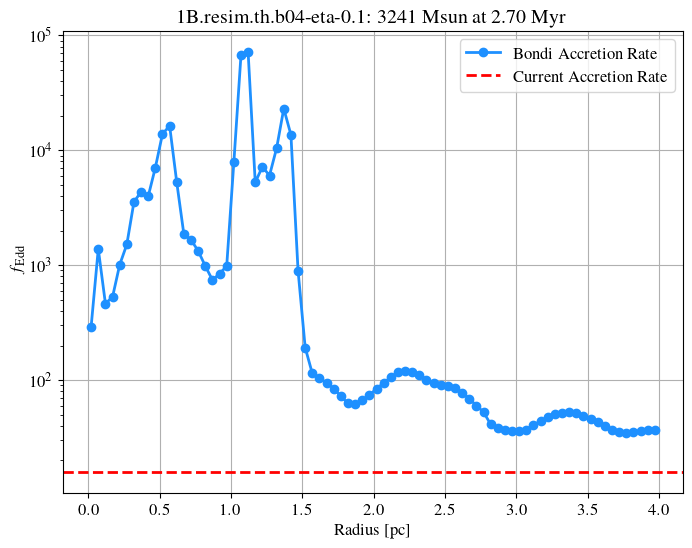

In [28]:

# Gravitational constant in cgs units
G = 6.67e-8*yt.units.cm**3/yt.units.g/yt.units.s**2

# Constants
gamma = 5/3  # Adiabatic index for monoatomic gas
mu = 0.6  # Mean molecular weight for ionized gas (assumed)

def eddington_rate(mparticle_msun: float):
    # eddington rate constants in cgs units
    PI = 3.1415927
    GravConst = 6.6740831e-8*yt.units.cm**3/yt.units.g/yt.units.s**2
    mh = 1.67262171e-24*yt.units.g
    clight = 2.99792458e10*yt.units.cm/yt.units.s
    sigma_thompson = 6.65E-25*yt.units.cm**2
    eta_disk = 0.1 # optically thick and e_radiative = 0.11
    SolarMass = 1.9891e33*yt.units.g
    mparticle_g = mparticle_msun.to('g')
    mdot_edd = 4.0 * PI * GravConst * mparticle_g * mh / (clight * eta_disk * sigma_thompson)
    return mdot_edd.to('Msun/yr')

def calculate_bondi_rate(ds, center, radius, M_BH):
    """
    Calculate the Bondi accretion rate through a spherical shell at a given radius.

    Parameters:
    ds : yt dataset
        The simulation dataset.
    center : array-like
        The center of the spherical shell (e.g., black hole position).
    radius : float
        The radius of the spherical shell (in pc).
    M_BH : yt.Quantity
        The mass of the black hole in solar masses (Msun).

    Returns:
    bondi_rate : yt.Quantity
        The Bondi accretion rate in solar masses per year (Msun/yr).
    """
    
    # Create a spherical shell with a small thickness
    center = center.in_units("pc")
    pos = (center[0] + radius, center[1], center[2])
    dx = ds.find_field_values_at_point([("index", "dx")], pos)[0].to('pc')
    print(f"dx = {dx:.2e}")
    shell = ds.sphere(center, radius + dx) - ds.sphere(center, radius)

    # Get the gas density and c_s and v fields
    density = shell[("gas", "density")].in_units("g/cm**3")  # Gas density in g/cm^3
    sound_speed = shell[("gas", "sound_speed")].in_units("cm/s")  # Sound speed in cm/s
    gas_velocity = shell[("gas", "velocity_magnitude")].in_units("cm/s")  # Gas velocity magnitude in cm/s
    M_BH = M_BH.to("g")  # Convert black hole mass to grams
    G = yt.physical_constants.G.to("cm**3/g/s**2")  # Gravitational constant in cgs units

    # Bondi rate: 4 * pi * G^2 * M_BH^2 * rho / c_s^3
    bondi_rate_per_cell = 4 * np.pi * G**2 * (M_BH**2) * density / (sound_speed**2 + gas_velocity**2)**(3/2)  # Bondi rate per cell

    # Take mean the Bondi rate over all cells in the shell
    total_bondi_rate = np.mean(bondi_rate_per_cell).to("Msun/yr")
    
    return total_bondi_rate

def plot_bondi_rate_profile(ds, center, M_BH, min_radius=0, max_radius=2, step=0.02, sim_name="", edd=False):
    """
    Plot the radial profile of Bondi accretion rate from 0 to 2 pc in steps of 0.02 pc.

    Parameters:
    ds : yt dataset
        The simulation dataset.
    center : array-like
        The center of the spherical shells (e.g., black hole position).
    M_BH : float
        The black hole mass in solar masses (Msun).
    min_radius : float
        The minimum radius to start calculating the Bondi rate (in pc).
    max_radius : float
        The maximum radius to stop calculating the Bondi rate (in pc).
    step : float
        The step size for the radial profile (in pc).
    """
    
    # Initialize arrays for radius and Bondi rates
    radii = np.arange(min_radius, max_radius, step)*yt.units.pc
    bondi_rates = []
    for r in radii:
        if edd:
            bondi_rate = calculate_bondi_rate(ds, center, r, M_BH)/ eddington_rate(M_BH)
        else:
            bondi_rate = calculate_bondi_rate(ds, center, r, M_BH)
        bondi_rates.append(bondi_rate)

        # Print out some useful information at each radius
        print(f"Radius = {r:.2f}, Bondi rate = {bondi_rate:.2e}")

    # Plotting the radial profile of Bondi accretion rate
    plt.figure(figsize=(8, 6))
    setup_plot_env()
    plt.plot(radii, bondi_rates, label="Bondi Accretion Rate", color='dodgerblue', lw=2, marker='o')
    ad = ds.all_data()
    accrate = ad["SmartStar", "AccretionRate"][:, -1].in_units("Msun/yr")/ eddington_rate(M_BH) if edd else ad["SmartStar", "AccretionRate"][:, -1].in_units("Msun/yr")
    plt.axhline(accrate, color='red', linestyle='--', label="Current Accretion Rate") if edd else None
    plt.xlabel("Radius [pc]")
    plt.ylabel("Bondi Accretion Rate [Msun/yr]") if not edd else plt.ylabel(r"$f_{\rm Edd}$")
    plt.title(f"{sim_name}: {M_BH:.0f} at {ss_age[0]/1e6:.2f} Myr")
    plt.grid(True)
    plt.yscale("log")
    plt.legend()
    plt.show()

# Example usage:
ds = yt.load("/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04-eta-0.1/DD0352/DD0352")
sim_name = "1B.resim.th.b04-eta-0.1"
ss_pos, ss_mass, ss_age = ss_properties(ds)
center = ss_pos  # Set this to your black hole position or desired center
M_BH =  ss_mass # Example black hole mass of 1 million solar masses

# Plot the radial profile of Bondi accretion rate
plot_bondi_rate_profile(ds, center, M_BH, min_radius=0.02*yt.units.pc, max_radius=4*yt.units.pc, step=0.05*yt.units.pc, sim_name=sim_name, edd=True)


yt : [INFO     ] 2024-10-25 08:54:13,065 Parameters: current_time              = 14.236022253282
yt : [INFO     ] 2024-10-25 08:54:13,067 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-25 08:54:13,069 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-25 08:54:13,071 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-25 08:54:13,073 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-25 08:54:13,074 Parameters: current_redshift          = 25.918740127656
yt : [INFO     ] 2024-10-25 08:54:13,076 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-25 08:54:13,077 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-25 08:54:13,078 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-25 08:54:13,081 Parameters: hubble_constant           = 0.71


ds =  DD0352


Parsing Hierarchy : 100%|██████████| 2750/2750 [00:00<00:00, 14834.72it/s]
yt : [INFO     ] 2024-10-25 08:54:13,342 Gathering a field list (this may take a moment.)


dx = 3.12e-03 pc
Radius = 0.02 pc, Bondi rate = 1.79e+03 dimensionless
dx = 6.24e-03 pc
Radius = 0.07 pc, Bondi rate = 8.16e+02 dimensionless
dx = 1.25e-02 pc
Radius = 0.12 pc, Bondi rate = 6.89e+02 dimensionless
dx = 1.25e-02 pc
Radius = 0.17 pc, Bondi rate = 4.14e+03 dimensionless
dx = 2.49e-02 pc
Radius = 0.22 pc, Bondi rate = 3.70e+03 dimensionless
dx = 2.49e-02 pc
Radius = 0.27 pc, Bondi rate = 5.06e+03 dimensionless
dx = 2.49e-02 pc
Radius = 0.32 pc, Bondi rate = 9.29e+03 dimensionless
dx = 4.99e-02 pc
Radius = 0.37 pc, Bondi rate = 7.49e+03 dimensionless
dx = 4.99e-02 pc
Radius = 0.42 pc, Bondi rate = 3.62e+04 dimensionless
dx = 4.99e-02 pc
Radius = 0.47 pc, Bondi rate = 1.72e+03 dimensionless
dx = 4.99e-02 pc
Radius = 0.52 pc, Bondi rate = 1.37e+03 dimensionless
dx = 4.99e-02 pc
Radius = 0.57 pc, Bondi rate = 1.51e+03 dimensionless
dx = 4.99e-02 pc
Radius = 0.62 pc, Bondi rate = 9.43e+02 dimensionless
dx = 4.99e-02 pc
Radius = 0.67 pc, Bondi rate = 1.15e+03 dimensionless
dx = 9

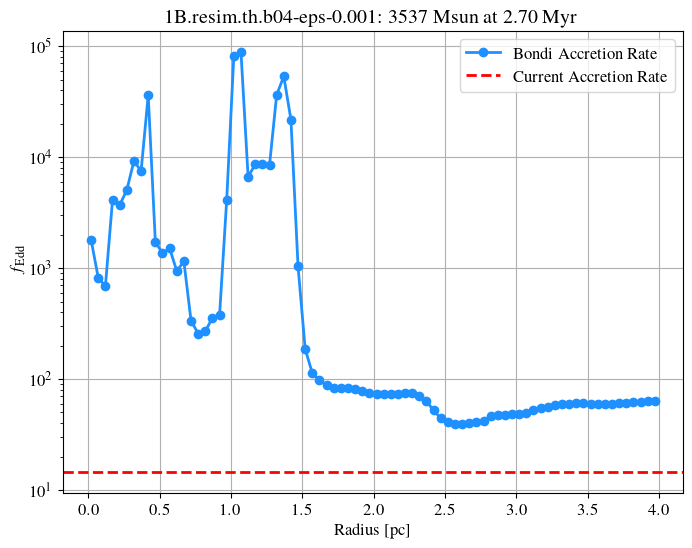

In [29]:
# Example usage:
ds = yt.load("/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04-eps-0.001/DD0352/DD0352")
sim_name = "1B.resim.th.b04-eps-0.001"
ss_pos, ss_mass, ss_age = ss_properties(ds)
center = ss_pos  # Set this to your black hole position or desired center
M_BH =  ss_mass # Example black hole mass of 1 million solar masses

# Plot the radial profile of Bondi accretion rate
plot_bondi_rate_profile(ds, center, M_BH, min_radius=0.02*yt.units.pc, max_radius=4*yt.units.pc, step=0.05*yt.units.pc, sim_name=sim_name, edd=True)

# Specific Energy Density in Feedback Regions

This is to be used as a volume-of-feedback-zone-independent measure of the intensity of the thermal feedback deposited in the simulations. Units are ergs/s/g.

Can we define a threshold below which feedback is ineffective?

## Event 1

In [41]:
E1_specific_heating_rate_means = []

yt : [INFO     ] 2024-10-25 09:50:45,719 Parameters: current_time              = 14.213796969306
yt : [INFO     ] 2024-10-25 09:50:45,721 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-25 09:50:45,723 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-25 09:50:45,724 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-25 09:50:45,725 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-25 09:50:45,727 Parameters: current_redshift          = 25.946794958957
yt : [INFO     ] 2024-10-25 09:50:45,728 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-25 09:50:45,729 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-25 09:50:45,730 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-25 09:50:45,731 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 2565/2565 [00:00<00:00, 13553.89it/s]
yt : [INFO     ] 2024-10-2

ds =  DD0153
r_cells: 5


yt : [INFO     ] 2024-10-25 09:51:22,249 xlim = 0.490380 0.490381
yt : [INFO     ] 2024-10-25 09:51:22,250 ylim = 0.494609 0.494610
yt : [INFO     ] 2024-10-25 09:51:22,259 xlim = 0.490380 0.490381
yt : [INFO     ] 2024-10-25 09:51:22,260 ylim = 0.494609 0.494610
yt : [INFO     ] 2024-10-25 09:51:22,267 Making a fixed resolution buffer of (('gas', 'BH_specific_heating_rate')) 800 by 800


bh_pos: [[0.49038045 0.49460922 0.50955757]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49038045 0.49460922 0.50955757]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49038045 0.49460922 0.50955757]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49038045 0.49460922 0.50955757]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49038045 0.49460922 0.50955757]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49038045 0.49460922 0.50955757]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49038045 0.49460922 0.50955757]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49038045 0.49460922 0.5095575


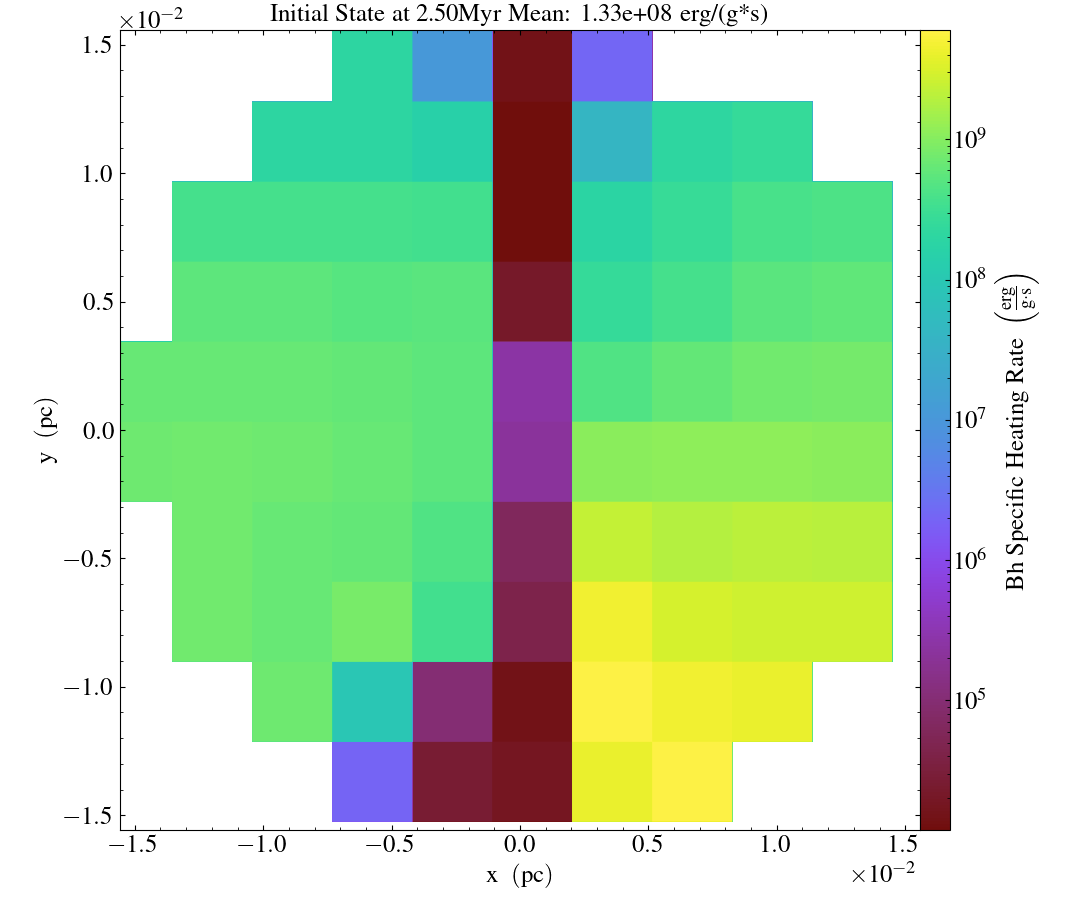

yt : [INFO     ] 2024-10-25 09:51:24,042 Parameters: current_time              = 14.236022253282
yt : [INFO     ] 2024-10-25 09:51:24,043 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-25 09:51:24,045 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-25 09:51:24,046 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-25 09:51:24,047 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-25 09:51:24,048 Parameters: current_redshift          = 25.918740127656
yt : [INFO     ] 2024-10-25 09:51:24,049 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-25 09:51:24,050 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-25 09:51:24,051 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-25 09:51:24,052 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 2794/2794 [00:00<00:00, 3242.45it/s]
yt : [INFO     ] 2024-10-25

ds =  DD0352
r_cells: 5


yt : [INFO     ] 2024-10-25 09:51:37,388 xlim = 0.490371 0.490372
yt : [INFO     ] 2024-10-25 09:51:37,390 ylim = 0.494603 0.494605
yt : [INFO     ] 2024-10-25 09:51:37,398 xlim = 0.490371 0.490372
yt : [INFO     ] 2024-10-25 09:51:37,400 ylim = 0.494603 0.494605
yt : [INFO     ] 2024-10-25 09:51:37,405 Making a fixed resolution buffer of (('gas', 'BH_specific_heating_rate')) 800 by 800


bh_pos: [[0.49037163 0.49460397 0.50954983]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460397 0.50954983]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460397 0.50954983]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460397 0.50954983]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460397 0.50954983]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460397 0.50954983]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460397 0.50954983]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460397 0.5095498


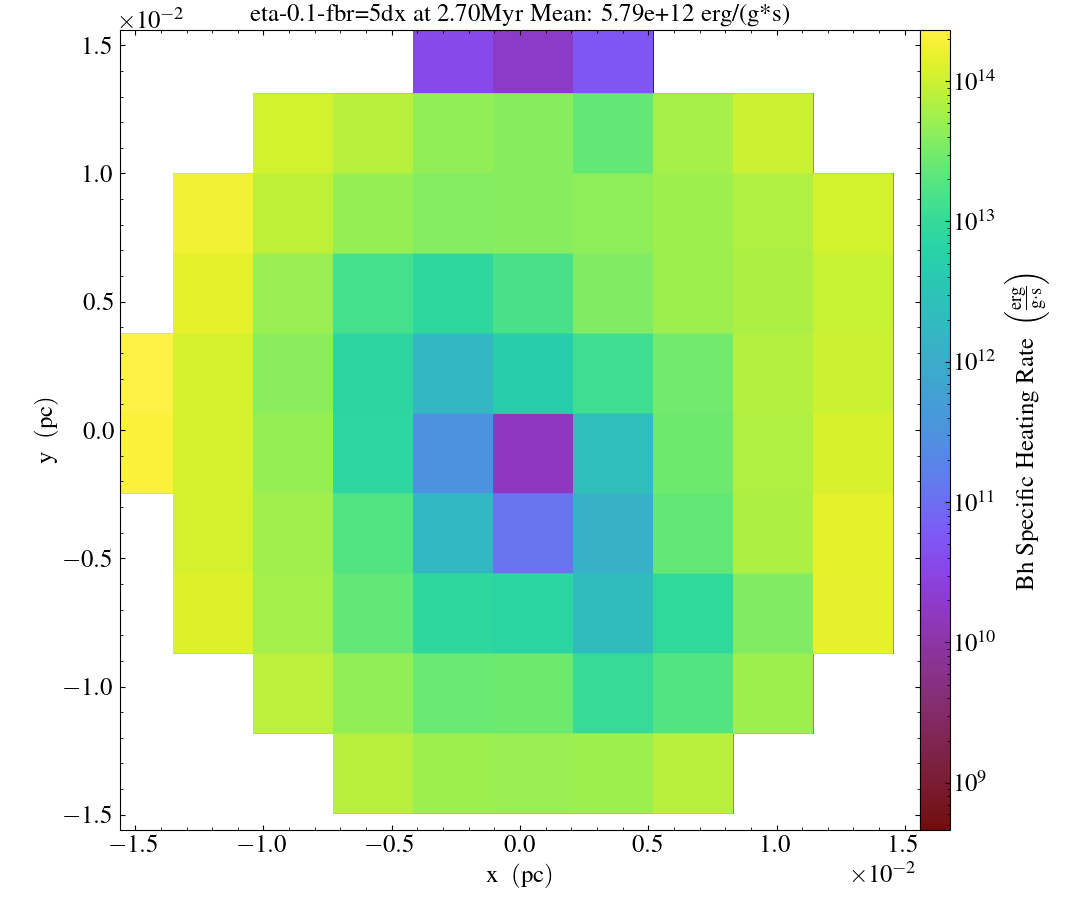

yt : [INFO     ] 2024-10-25 09:51:39,707 Parameters: current_time              = 14.236022253282
yt : [INFO     ] 2024-10-25 09:51:39,709 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-25 09:51:39,710 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-25 09:51:39,712 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-25 09:51:39,713 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-25 09:51:39,714 Parameters: current_redshift          = 25.918740127656
yt : [INFO     ] 2024-10-25 09:51:39,716 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-25 09:51:39,717 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-25 09:51:39,718 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-25 09:51:39,718 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 2827/2827 [00:00<00:00, 3450.66it/s]
yt : [INFO     ] 2024-10-25

ds =  DD0352
r_cells: 7


yt : [INFO     ] 2024-10-25 09:52:24,244 xlim = 0.490371 0.490372
yt : [INFO     ] 2024-10-25 09:52:24,247 ylim = 0.494603 0.494605
yt : [INFO     ] 2024-10-25 09:52:24,255 xlim = 0.490371 0.490372
yt : [INFO     ] 2024-10-25 09:52:24,257 ylim = 0.494603 0.494605
yt : [INFO     ] 2024-10-25 09:52:24,262 Making a fixed resolution buffer of (('gas', 'BH_specific_heating_rate')) 800 by 800


bh_pos: [[0.49037166 0.49460399 0.50954983]] code_length, bh_r: [8.34465027e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037166 0.49460399 0.50954983]] code_length, bh_r: [8.34465027e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037166 0.49460399 0.50954983]] code_length, bh_r: [8.34465027e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037166 0.49460399 0.50954983]] code_length, bh_r: [8.34465027e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037166 0.49460399 0.50954983]] code_length, bh_r: [8.34465027e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037166 0.49460399 0.50954983]] code_length, bh_r: [8.34465027e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037166 0.49460399 0.50954983]] code_length, bh_r: [8.34465027e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037166 0.49460399 0.5095498


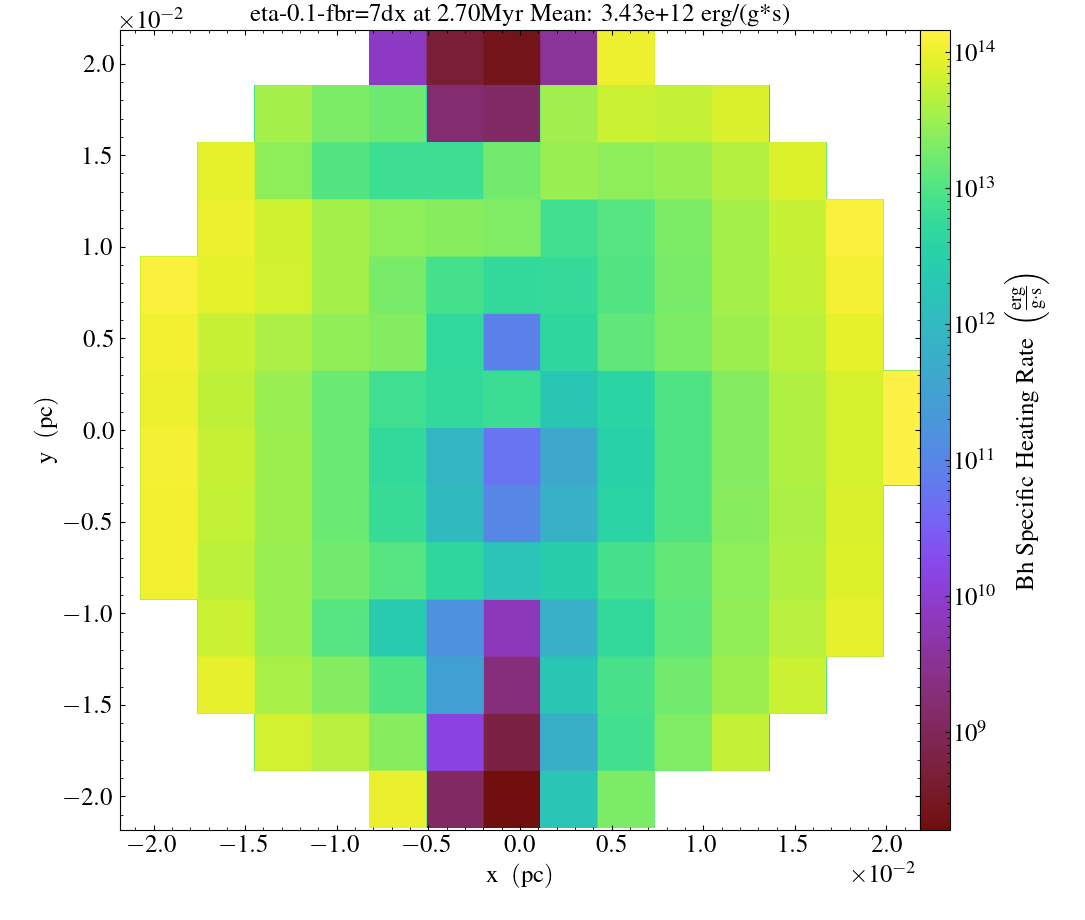

yt : [INFO     ] 2024-10-25 09:52:27,176 Parameters: current_time              = 14.236022253282
yt : [INFO     ] 2024-10-25 09:52:27,178 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-25 09:52:27,179 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-25 09:52:27,181 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-25 09:52:27,182 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-25 09:52:27,183 Parameters: current_redshift          = 25.918740127656
yt : [INFO     ] 2024-10-25 09:52:27,186 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-25 09:52:27,187 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-25 09:52:27,189 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-25 09:52:27,190 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 2745/2745 [00:00<00:00, 3814.62it/s]
yt : [INFO     ] 2024-10-25

ds =  DD0352
r_cells: 10


yt : [INFO     ] 2024-10-25 09:53:08,867 xlim = 0.490370 0.490373
yt : [INFO     ] 2024-10-25 09:53:08,869 ylim = 0.494603 0.494605
yt : [INFO     ] 2024-10-25 09:53:08,877 xlim = 0.490370 0.490373
yt : [INFO     ] 2024-10-25 09:53:08,878 ylim = 0.494603 0.494605
yt : [INFO     ] 2024-10-25 09:53:08,883 Making a fixed resolution buffer of (('gas', 'BH_specific_heating_rate')) 800 by 800


bh_pos: [[0.49037163 0.49460397 0.50954984]] code_length, bh_r: [1.1920929e-06] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460397 0.50954984]] code_length, bh_r: [1.1920929e-06] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460397 0.50954984]] code_length, bh_r: [1.1920929e-06] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460397 0.50954984]] code_length, bh_r: [1.1920929e-06] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460397 0.50954984]] code_length, bh_r: [1.1920929e-06] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460397 0.50954984]] code_length, bh_r: [1.1920929e-06] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460397 0.50954984]] code_length, bh_r: [1.1920929e-06] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460397 0.50954984]] cod


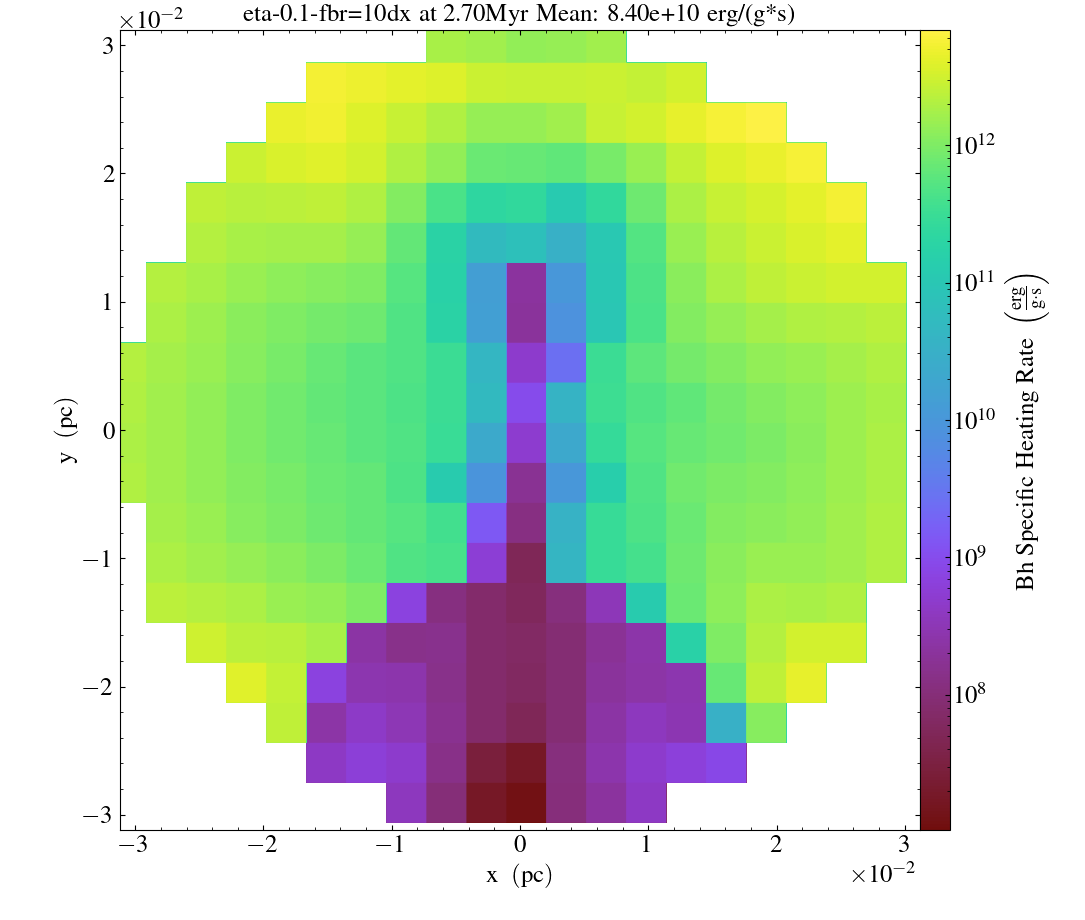

yt : [INFO     ] 2024-10-25 09:53:10,689 Parameters: current_time              = 14.255679763682
yt : [INFO     ] 2024-10-25 09:53:10,691 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-25 09:53:10,693 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-25 09:53:10,694 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-25 09:53:10,695 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-25 09:53:10,697 Parameters: current_redshift          = 25.893987347198
yt : [INFO     ] 2024-10-25 09:53:10,698 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-25 09:53:10,699 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-25 09:53:10,699 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-25 09:53:10,700 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 3398/3398 [00:00<00:00, 4372.29it/s]
yt : [INFO     ] 2024-10-25

ds =  DD0330
r_cells: 5


yt : [INFO     ] 2024-10-25 09:53:59,007 xlim = 0.490363 0.490365
yt : [INFO     ] 2024-10-25 09:53:59,009 ylim = 0.494599 0.494600
yt : [INFO     ] 2024-10-25 09:53:59,016 xlim = 0.490363 0.490365
yt : [INFO     ] 2024-10-25 09:53:59,018 ylim = 0.494599 0.494600
yt : [INFO     ] 2024-10-25 09:53:59,024 Making a fixed resolution buffer of (('gas', 'BH_specific_heating_rate')) 800 by 800


bh_pos: [[0.49036395 0.49459989 0.5095412 ]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036395 0.49459989 0.5095412 ]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036395 0.49459989 0.5095412 ]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036395 0.49459989 0.5095412 ]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036395 0.49459989 0.5095412 ]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036395 0.49459989 0.5095412 ]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036395 0.49459989 0.5095412 ]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036395 0.49459989 0.5095412


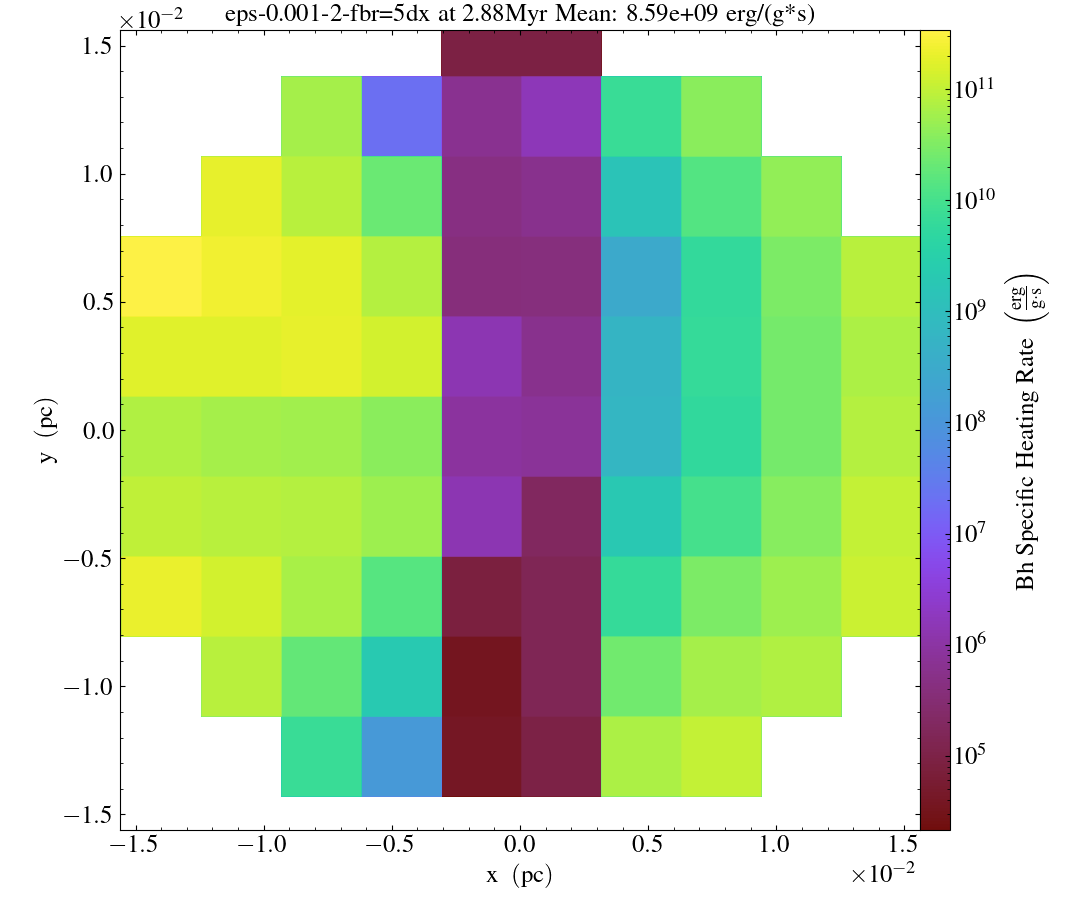

yt : [INFO     ] 2024-10-25 09:54:01,182 Parameters: current_time              = 14.236022253282
yt : [INFO     ] 2024-10-25 09:54:01,183 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-25 09:54:01,185 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-25 09:54:01,186 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-25 09:54:01,188 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-25 09:54:01,189 Parameters: current_redshift          = 25.918740127656
yt : [INFO     ] 2024-10-25 09:54:01,190 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-25 09:54:01,191 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-25 09:54:01,193 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-25 09:54:01,194 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 2750/2750 [00:00<00:00, 14252.63it/s]
yt : [INFO     ] 2024-10-2

ds =  DD0352
r_cells: 5


yt : [INFO     ] 2024-10-25 09:54:11,537 xlim = 0.490371 0.490372
yt : [INFO     ] 2024-10-25 09:54:11,539 ylim = 0.494603 0.494605
yt : [INFO     ] 2024-10-25 09:54:11,548 xlim = 0.490371 0.490372
yt : [INFO     ] 2024-10-25 09:54:11,549 ylim = 0.494603 0.494605
yt : [INFO     ] 2024-10-25 09:54:11,554 Making a fixed resolution buffer of (('gas', 'BH_specific_heating_rate')) 800 by 800


bh_pos: [[0.49037163 0.49460398 0.50954984]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460398 0.50954984]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460398 0.50954984]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460398 0.50954984]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460398 0.50954984]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460398 0.50954984]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460398 0.50954984]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49037163 0.49460398 0.5095498


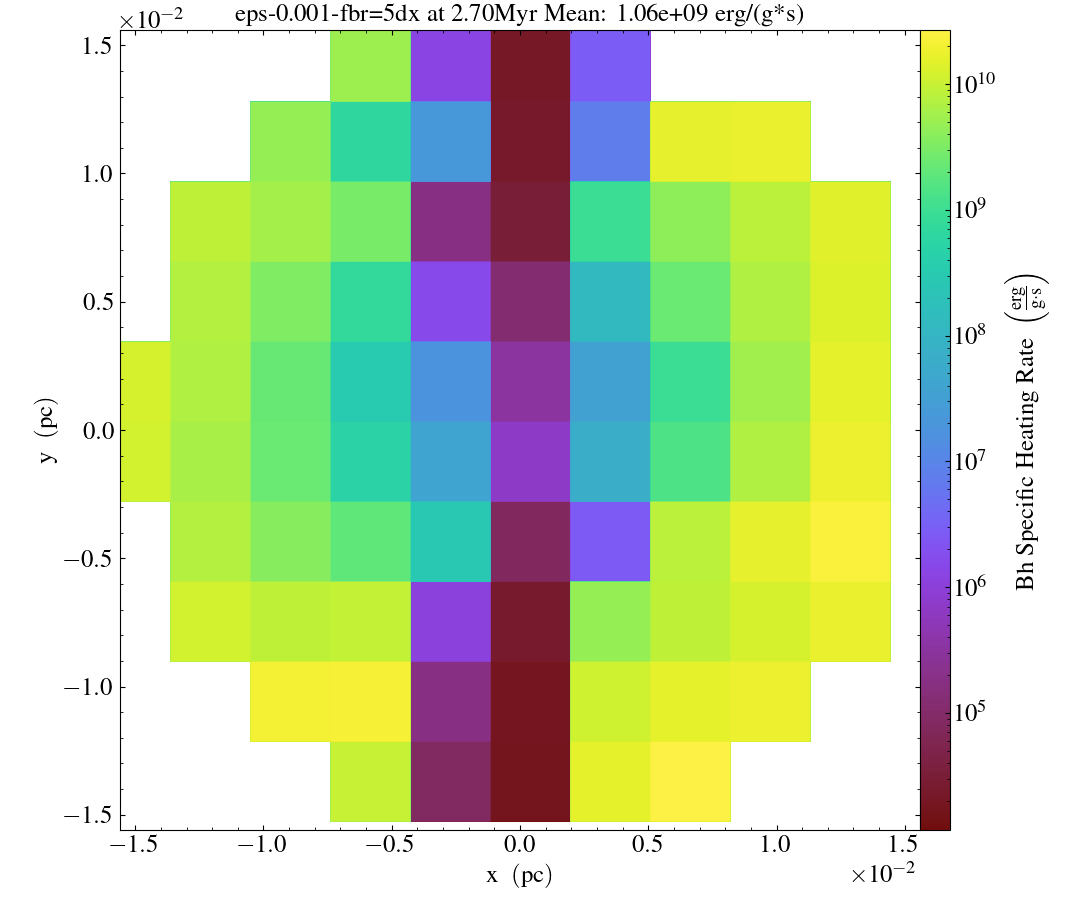

yt : [INFO     ] 2024-10-25 09:54:13,655 Parameters: current_time              = 14.258360333282
yt : [INFO     ] 2024-10-25 09:54:13,657 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-25 09:54:13,658 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-25 09:54:13,660 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-25 09:54:13,661 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-25 09:54:13,662 Parameters: current_redshift          = 25.890616375298
yt : [INFO     ] 2024-10-25 09:54:13,663 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-25 09:54:13,664 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-25 09:54:13,665 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-25 09:54:13,666 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 3291/3291 [00:00<00:00, 16825.89it/s]
yt : [INFO     ] 2024-10-2

ds =  DD0354
r_cells: 5


yt : [INFO     ] 2024-10-25 09:54:32,722 xlim = 0.490362 0.490363
yt : [INFO     ] 2024-10-25 09:54:32,724 ylim = 0.494600 0.494601
yt : [INFO     ] 2024-10-25 09:54:32,732 xlim = 0.490362 0.490363
yt : [INFO     ] 2024-10-25 09:54:32,734 ylim = 0.494600 0.494601
yt : [INFO     ] 2024-10-25 09:54:32,739 Making a fixed resolution buffer of (('gas', 'BH_specific_heating_rate')) 800 by 800


bh_pos: [[0.49036286 0.49460028 0.50954208]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036286 0.49460028 0.50954208]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036286 0.49460028 0.50954208]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036286 0.49460028 0.50954208]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036286 0.49460028 0.50954208]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036286 0.49460028 0.50954208]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036286 0.49460028 0.50954208]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036286 0.49460028 0.5095420


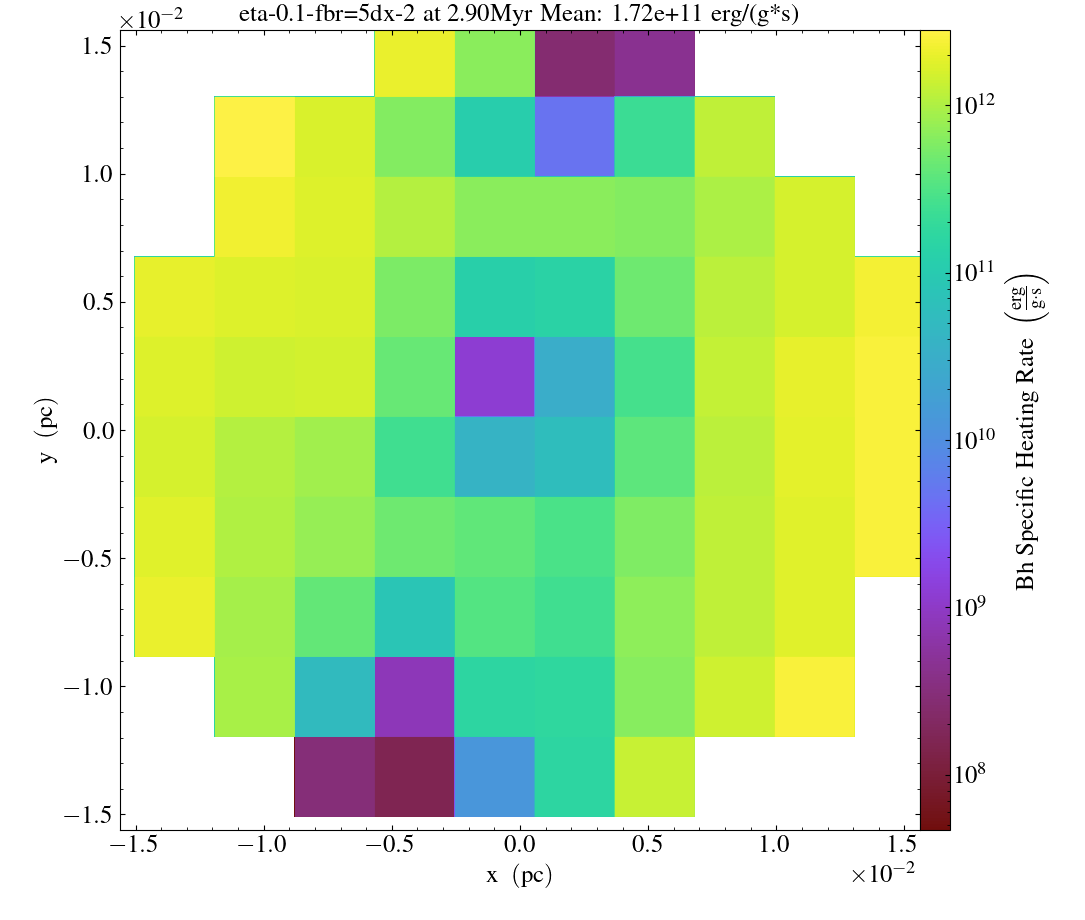

yt : [INFO     ] 2024-10-25 09:54:33,686 Parameters: current_time              = 14.258360333282
yt : [INFO     ] 2024-10-25 09:54:33,688 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-25 09:54:33,689 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-25 09:54:33,691 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-25 09:54:33,692 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-25 09:54:33,694 Parameters: current_redshift          = 25.890616375298
yt : [INFO     ] 2024-10-25 09:54:33,695 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-25 09:54:33,696 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-25 09:54:33,697 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-25 09:54:33,698 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 2345/2345 [00:00<00:00, 2812.32it/s]
yt : [INFO     ] 2024-10-25

ds =  DD0354
r_cells: 5


yt : [INFO     ] 2024-10-25 09:54:48,252 xlim = 0.490360 0.490365
yt : [INFO     ] 2024-10-25 09:54:48,254 ylim = 0.494643 0.494648
yt : [INFO     ] 2024-10-25 09:54:48,262 xlim = 0.490360 0.490365
yt : [INFO     ] 2024-10-25 09:54:48,263 ylim = 0.494643 0.494648
yt : [INFO     ] 2024-10-25 09:54:48,268 Making a fixed resolution buffer of (('gas', 'BH_specific_heating_rate')) 800 by 800


bh_pos: [[0.49036222 0.4946456  0.5095712 ]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [9.60172052e-07] code_mass/code_time
bh_pos: [[0.49036222 0.4946456  0.5095712 ]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [9.60172052e-07] code_mass/code_time
bh_pos: [[0.49036222 0.4946456  0.5095712 ]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [9.60172052e-07] code_mass/code_time
bh_pos: [[0.49036222 0.4946456  0.5095712 ]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [9.60172052e-07] code_mass/code_time
bh_pos: [[0.49036222 0.4946456  0.5095712 ]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [9.60172052e-07] code_mass/code_time
bh_pos: [[0.49036222 0.4946456  0.5095712 ]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [9.60172052e-07] code_mass/code_time
bh_pos: [[0.49036222 0.4946456  0.5095712 ]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [9.60172052e-07] code_mass/code_time
bh_pos: [[0.49036222 0.4946456  0.5095712


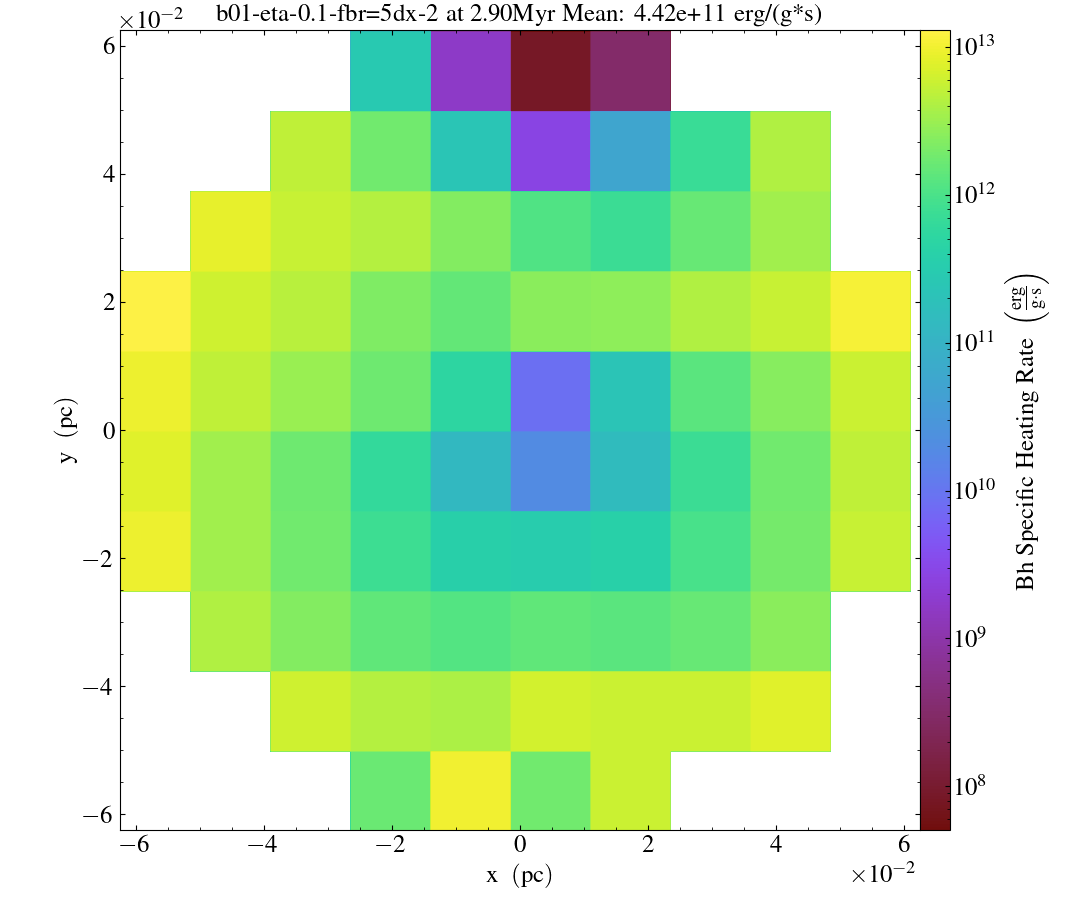

yt : [INFO     ] 2024-10-25 09:54:49,209 Parameters: current_time              = 14.258472124193
yt : [INFO     ] 2024-10-25 09:54:49,210 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-25 09:54:49,212 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-25 09:54:49,213 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-25 09:54:49,215 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-25 09:54:49,216 Parameters: current_redshift          = 25.89047581468
yt : [INFO     ] 2024-10-25 09:54:49,217 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-25 09:54:49,219 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-25 09:54:49,221 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-25 09:54:49,222 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 2307/2307 [00:00<00:00, 3590.86it/s]
yt : [INFO     ] 2024-10-25 

ds =  DD0211
r_cells: 5


yt : [INFO     ] 2024-10-25 09:54:53,974 xlim = 0.490359 0.490364
yt : [INFO     ] 2024-10-25 09:54:53,976 ylim = 0.494645 0.494650
yt : [INFO     ] 2024-10-25 09:54:53,984 xlim = 0.490359 0.490364
yt : [INFO     ] 2024-10-25 09:54:53,986 ylim = 0.494645 0.494650
yt : [INFO     ] 2024-10-25 09:54:53,991 Making a fixed resolution buffer of (('gas', 'BH_specific_heating_rate')) 800 by 800


bh_pos: [[0.49036176 0.49464727 0.50956978]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [9.60172052e-07] code_mass/code_time
bh_pos: [[0.49036176 0.49464727 0.50956978]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [9.60172052e-07] code_mass/code_time
bh_pos: [[0.49036176 0.49464727 0.50956978]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [9.60172052e-07] code_mass/code_time
bh_pos: [[0.49036176 0.49464727 0.50956978]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [9.60172052e-07] code_mass/code_time
bh_pos: [[0.49036176 0.49464727 0.50956978]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [9.60172052e-07] code_mass/code_time
bh_pos: [[0.49036176 0.49464727 0.50956978]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [9.60172052e-07] code_mass/code_time
bh_pos: [[0.49036176 0.49464727 0.50956978]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [9.60172052e-07] code_mass/code_time
bh_pos: [[0.49036176 0.49464727 0.5095697


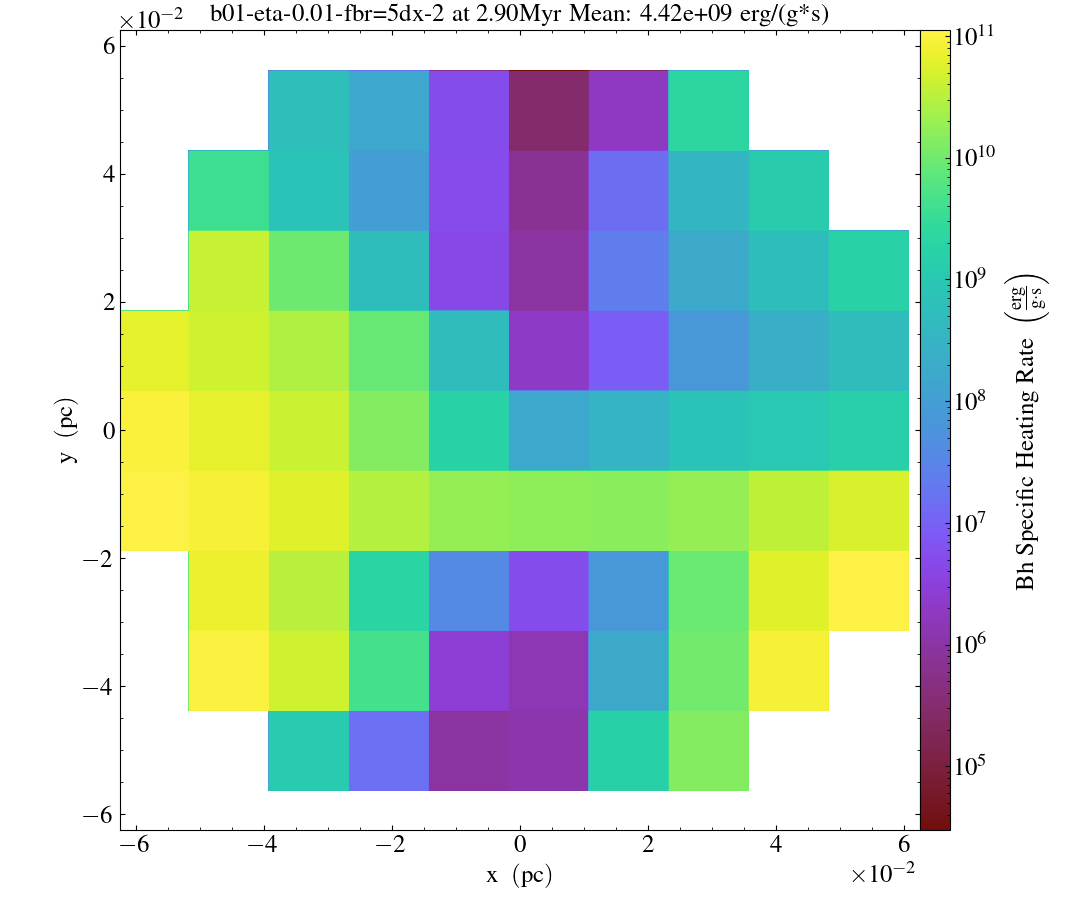

yt : [INFO     ] 2024-10-25 09:54:54,892 Parameters: current_time              = 14.258360333282
yt : [INFO     ] 2024-10-25 09:54:54,894 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-25 09:54:54,895 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-25 09:54:54,896 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-25 09:54:54,897 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-25 09:54:54,898 Parameters: current_redshift          = 25.890616375298
yt : [INFO     ] 2024-10-25 09:54:54,899 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-25 09:54:54,900 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-25 09:54:54,901 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-25 09:54:54,902 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 2642/2642 [00:00<00:00, 4073.28it/s]
yt : [INFO     ] 2024-10-25

ds =  DD1047


yt : [INFO     ] 2024-10-25 09:54:57,604 xlim = 0.490362 0.490363


r_cells: 5
bh_pos: [[0.49036248 0.49459675 0.50954288]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036248 0.49459675 0.50954288]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036248 0.49459675 0.50954288]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036248 0.49459675 0.50954288]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036248 0.49459675 0.50954288]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036248 0.49459675 0.50954288]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036248 0.49459675 0.50954288]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time


yt : [INFO     ] 2024-10-25 09:54:57,607 ylim = 0.494596 0.494597
yt : [INFO     ] 2024-10-25 09:54:57,610 xlim = 0.490362 0.490363
yt : [INFO     ] 2024-10-25 09:54:57,612 ylim = 0.494596 0.494597
yt : [INFO     ] 2024-10-25 09:54:57,616 Making a fixed resolution buffer of (('gas', 'BH_specific_heating_rate')) 800 by 800


bh_pos: [[0.49036248 0.49459675 0.50954288]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036248 0.49459675 0.50954288]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036248 0.49459675 0.50954288]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036248 0.49459675 0.50954288]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036248 0.49459675 0.50954288]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036248 0.49459675 0.50954288]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time
bh_pos: [[0.49036248 0.49459675 0.50954288]] code_length, bh_r: [5.96046448e-07] code_length, mdot: [7.86041174e-07] code_mass/code_time



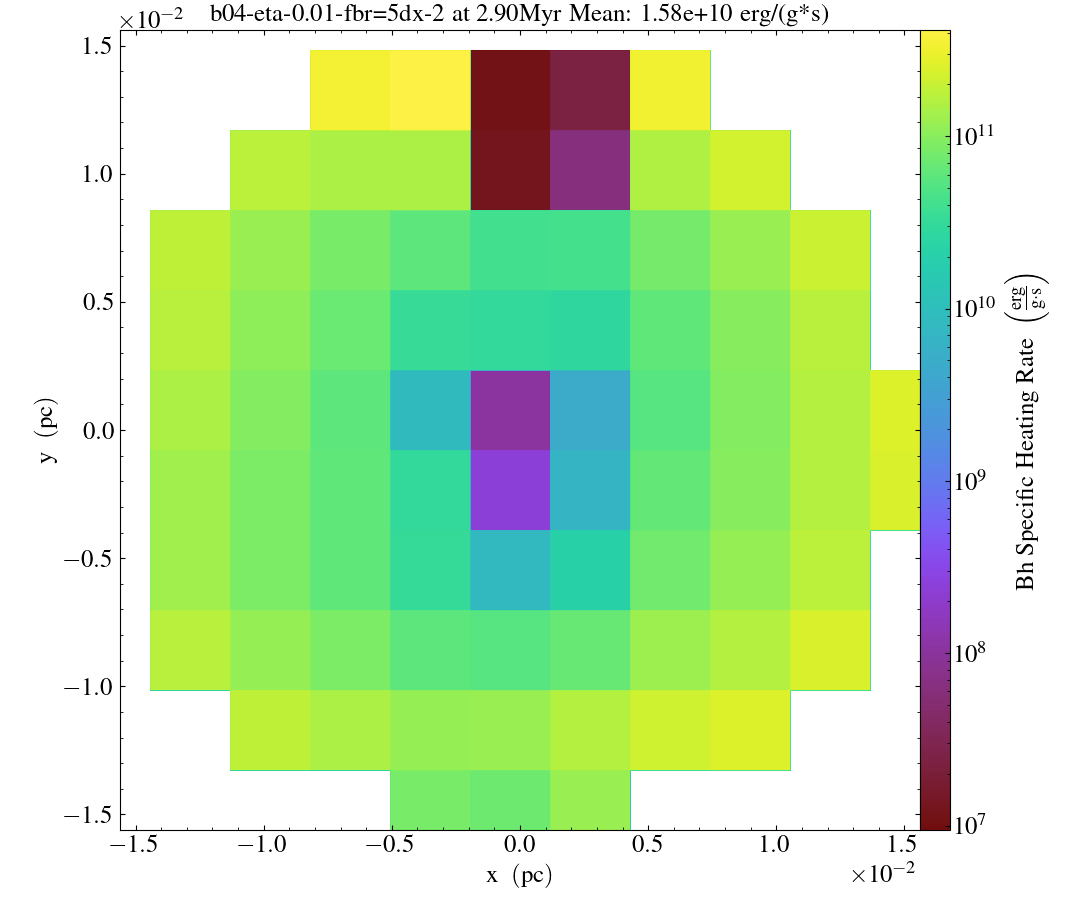

In [42]:
simulations_1 = [
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04/DD0153/DD0153", "name": "Initial State", "epsilon": 1e-5},
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04-eta-0.1/DD0352/DD0352", "name": "eta-0.1-fbr=5dx", "epsilon": 0.005 },
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04-eta-0.1/fb-r-7dx/DD0352/DD0352", "name": "eta-0.1-fbr=7dx", "epsilon": 0.005},
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04-eta-0.1/fb-r-10dx/DD0352/DD0352", "name": "eta-0.1-fbr=10dx", "epsilon": 0.005},
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04-eps-0.001-2/DD0330/DD0330", "name": "eps-0.001-2-fbr=5dx", "epsilon": 1e-5},
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04-eps-0.001/DD0352/DD0352", "name": "eps-0.001-fbr=5dx", "epsilon": 1e-5},
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04-eta-0.1-2/DD0354/DD0354", "name": "eta-0.1-fbr=5dx-2", "epsilon": 0.005},# 2.90 Myr
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b01-eta-0.1-2/DD0354/DD0354", "name": "b01-eta-0.1-fbr=5dx-2", "epsilon": 0.005}, # 2.90 Myr
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b01-eta-0.01-2/DD0211/DD0211", "name": "b01-eta-0.01-fbr=5dx-2", "epsilon": 0.0005}, # 2.90 Myr
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b04-eta-0.01-2/DD1047/DD1047", "name": "b04-eta-0.01-fbr=5dx-2", "epsilon": 0.0005}, # 2.90 Myr

]
for sim in simulations_1:
    ds = yt.load(sim["path"])
    ad = ds.all_data()

    # feedback sphere around black hole
    pos = ad["SmartStar", "particle_position"][0]
    pos, mass, age = ss_properties(ds)
    try:
        r_cells = ds.parameters['SmartStarBHThermalFeedbackRadiusinCells']
        if r_cells == 0:
            r_cells = 5
    except KeyError:
        r_cells = 5
    print(f"r_cells: {r_cells}")
    dx = ds.find_field_values_at_point([("index", "dx")], pos)[0].to('pc')
    sphere = ds.sphere(pos, dx * r_cells)

    bh_prepare_object(sphere, epsilon=sim["epsilon"])

    ds.add_field(("gas", "BH_specific_heating_rate"), function=_bh_specific_heating_rate, sampling_type="local", units="erg/s/g", force_override=True)
    ds.add_field(("gas", "BH_accretion_cooling_time"), function=_bh_accretion_cooling_time, sampling_type="local", units="s", force_override=True)
    ds.add_field(("gas", "BH_accretion_heating_to_cooling_ratio"), function=_bh_accretion_heating_to_cooling_ratio, sampling_type="local", units="", force_override=True)

    p = yt.SlicePlot(ds, "z", [("gas", "BH_specific_heating_rate")],
                        data_source=sphere, center=sphere.center,
                        width=2*sphere.radius.to('pc'))
    #p.set_unit("BH_accretion_cooling_time", "Myr")
    mean_rate = np.mean(sphere[("gas", "BH_specific_heating_rate")])
    E1_specific_heating_rate_means.append({"name": sim["name"], "mean [erg/(g*s)]": mean_rate.d})
    p.annotate_title(f"{sim['name']} at {age[0]/1e6:.2f}Myr Mean: {mean_rate:.2e}")
    p.show()


In [45]:
df = pd.DataFrame(E1_specific_heating_rate_means, columns=["name", "mean [erg/(g*s)]"])
df_sorted = df.sort_values(by="mean [erg/(g*s)]", ascending=True)
df_sorted["mean [erg/(g*s)]"] = df_sorted["mean [erg/(g*s)]"].apply(lambda x: f'{x:.2e}')
df_sorted

,name,mean [erg/(g*s)]
0,Initial State,1.33e+08
5,eps-0.001-fbr=5dx,1.06e+09
8,b01-eta-0.01-fbr=5dx-2,4.42e+09
4,eps-0.001-2-fbr=5dx,8.59e+09
9,b04-eta-0.01-fbr=5dx-2,1.58e+10
3,eta-0.1-fbr=10dx,8.40e+10
6,eta-0.1-fbr=5dx-2,1.72e+11
7,b01-eta-0.1-fbr=5dx-2,4.42e+11
2,eta-0.1-fbr=7dx,3.43e+12
1,eta-0.1-fbr=5dx,5.79e+12


## Event 2

In [ ]:
E2_specific_heating_rate_means = []

yt : [INFO     ] 2024-10-25 15:25:20,015 Parameters: current_time              = 17.497683497362
yt : [INFO     ] 2024-10-25 15:25:20,017 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-25 15:25:20,018 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-25 15:25:20,019 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-25 15:25:20,020 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-25 15:25:20,021 Parameters: current_redshift          = 22.459746672602
yt : [INFO     ] 2024-10-25 15:25:20,022 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-25 15:25:20,024 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-25 15:25:20,025 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-25 15:25:20,026 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 3903/3903 [00:00<00:00, 5043.70it/s] 
yt : [INFO     ] 2024-10-2

ds =  DD0653
r_cells: 5


yt : [INFO     ] 2024-10-25 15:26:22,147 xlim = 0.488054 0.488058
yt : [INFO     ] 2024-10-25 15:26:22,149 ylim = 0.492873 0.492878
yt : [INFO     ] 2024-10-25 15:26:22,157 xlim = 0.488054 0.488058
yt : [INFO     ] 2024-10-25 15:26:22,158 ylim = 0.492873 0.492878
yt : [INFO     ] 2024-10-25 15:26:22,164 Making a fixed resolution buffer of (('gas', 'BH_specific_heating_rate')) 800 by 800


bh_pos: [[0.48805594 0.49287546 0.5082585 ]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [1.76354479e-06] code_mass/code_time
bh_pos: [[0.48805594 0.49287546 0.5082585 ]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [1.76354479e-06] code_mass/code_time
bh_pos: [[0.48805594 0.49287546 0.5082585 ]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [1.76354479e-06] code_mass/code_time
bh_pos: [[0.48805594 0.49287546 0.5082585 ]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [1.76354479e-06] code_mass/code_time
bh_pos: [[0.48805594 0.49287546 0.5082585 ]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [1.76354479e-06] code_mass/code_time
bh_pos: [[0.48805594 0.49287546 0.5082585 ]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [1.76354479e-06] code_mass/code_time
bh_pos: [[0.48805594 0.49287546 0.5082585 ]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [1.76354479e-06] code_mass/code_time
bh_pos: [[0.48805594 0.49287546 0.5082585


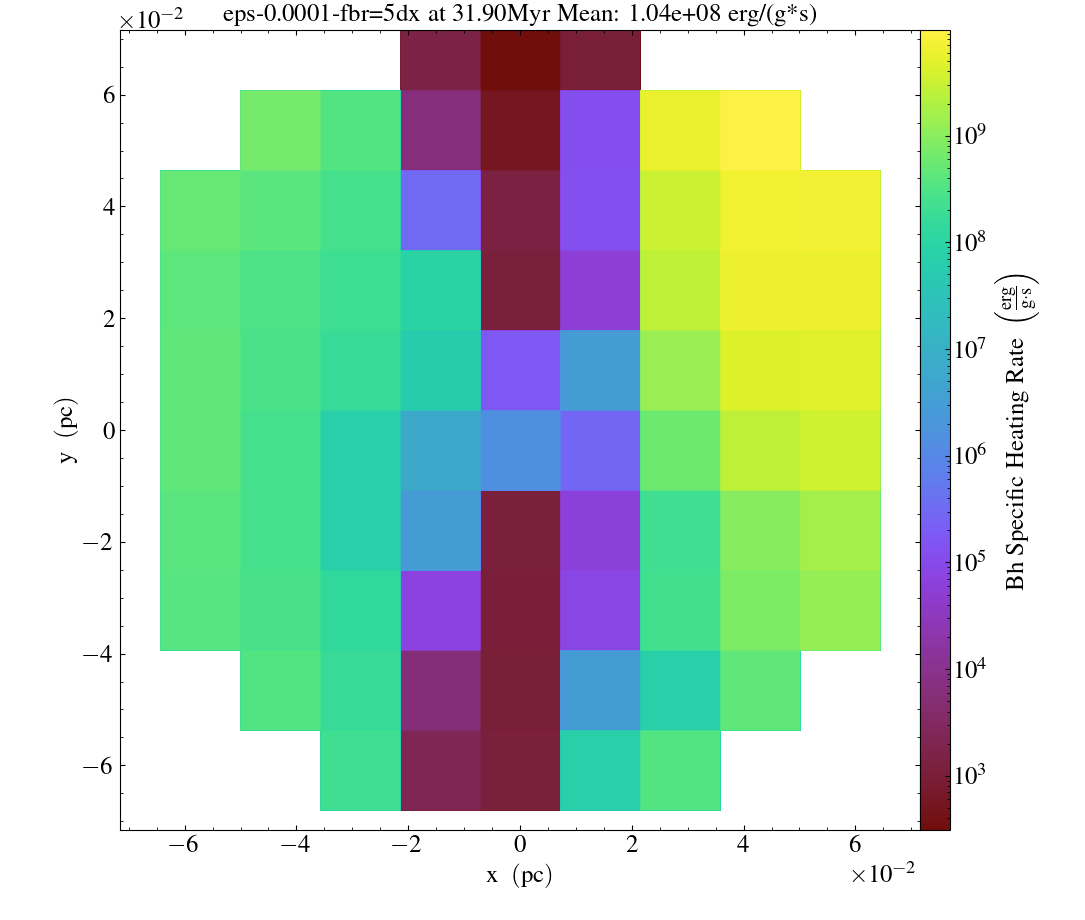

yt : [INFO     ] 2024-10-25 15:26:23,908 Parameters: current_time              = 17.497413206594
yt : [INFO     ] 2024-10-25 15:26:23,910 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-25 15:26:23,911 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-25 15:26:23,914 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-25 15:26:23,915 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-25 15:26:23,916 Parameters: current_redshift          = 22.459988284746
yt : [INFO     ] 2024-10-25 15:26:23,917 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-25 15:26:23,919 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-25 15:26:23,920 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-25 15:26:23,921 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 3838/3838 [00:01<00:00, 3122.13it/s] 
yt : [INFO     ] 2024-10-2

ds =  DD2783
r_cells: 5


yt : [INFO     ] 2024-10-25 15:27:21,099 xlim = 0.488054 0.488059
yt : [INFO     ] 2024-10-25 15:27:21,100 ylim = 0.492873 0.492878
yt : [INFO     ] 2024-10-25 15:27:21,107 xlim = 0.488054 0.488059
yt : [INFO     ] 2024-10-25 15:27:21,108 ylim = 0.492873 0.492878
yt : [INFO     ] 2024-10-25 15:27:21,112 Making a fixed resolution buffer of (('gas', 'BH_specific_heating_rate')) 800 by 800


bh_pos: [[0.48805646 0.49287573 0.50825833]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [8.31058851e-07] code_mass/code_time
bh_pos: [[0.48805646 0.49287573 0.50825833]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [8.31058851e-07] code_mass/code_time
bh_pos: [[0.48805646 0.49287573 0.50825833]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [8.31058851e-07] code_mass/code_time
bh_pos: [[0.48805646 0.49287573 0.50825833]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [8.31058851e-07] code_mass/code_time
bh_pos: [[0.48805646 0.49287573 0.50825833]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [8.31058851e-07] code_mass/code_time
bh_pos: [[0.48805646 0.49287573 0.50825833]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [8.31058851e-07] code_mass/code_time
bh_pos: [[0.48805646 0.49287573 0.50825833]] code_length, bh_r: [2.38418579e-06] code_length, mdot: [8.31058851e-07] code_mass/code_time
bh_pos: [[0.48805646 0.49287573 0.5082583


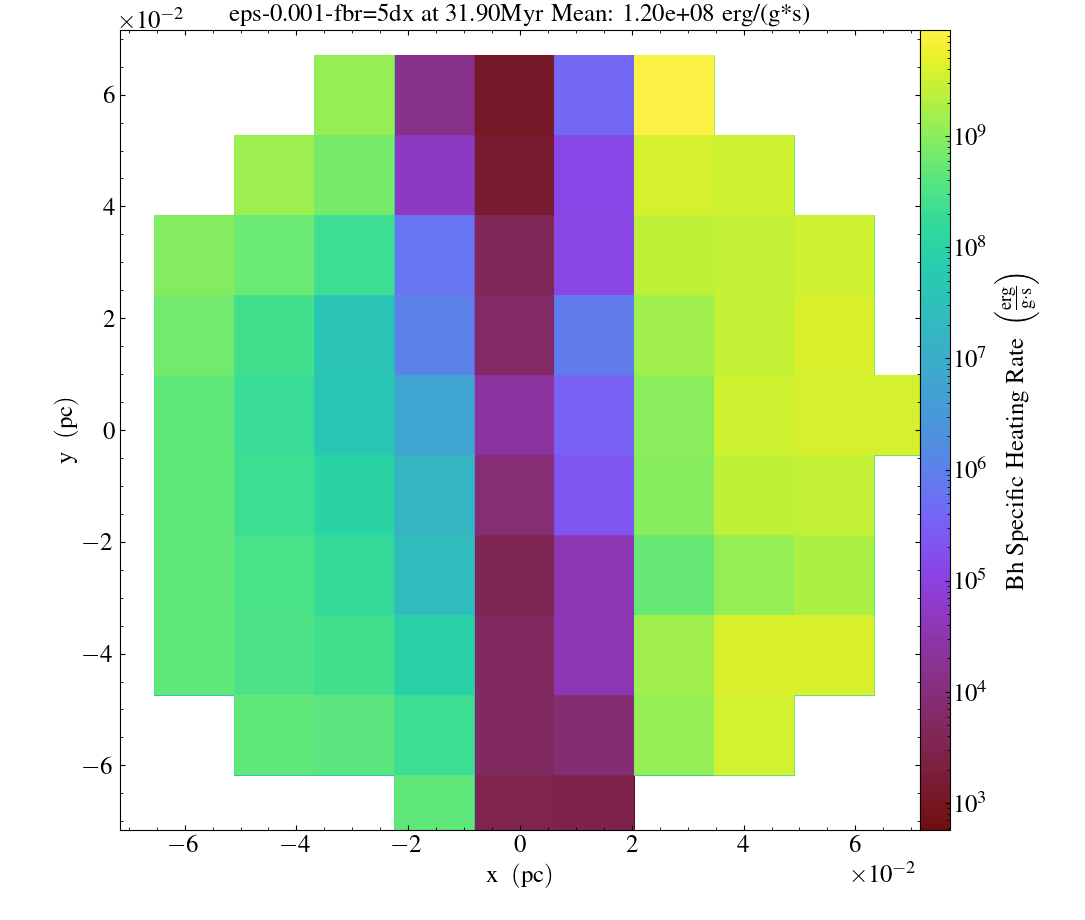

yt : [INFO     ] 2024-10-25 15:27:22,539 Parameters: current_time              = 17.497649990242
yt : [INFO     ] 2024-10-25 15:27:22,539 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-25 15:27:22,540 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-25 15:27:22,541 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-25 15:27:22,542 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-25 15:27:22,543 Parameters: current_redshift          = 22.459776624183
yt : [INFO     ] 2024-10-25 15:27:22,544 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-25 15:27:22,545 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-25 15:27:22,545 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-25 15:27:22,546 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 3949/3949 [00:00<00:00, 6074.53it/s]
yt : [INFO     ] 2024-10-25

ds =  DD0704
r_cells: 7


yt : [INFO     ] 2024-10-25 15:28:21,925 xlim = 0.488055 0.488062
yt : [INFO     ] 2024-10-25 15:28:21,927 ylim = 0.492872 0.492879
yt : [INFO     ] 2024-10-25 15:28:21,935 xlim = 0.488055 0.488062
yt : [INFO     ] 2024-10-25 15:28:21,936 ylim = 0.492872 0.492879
yt : [INFO     ] 2024-10-25 15:28:21,940 Making a fixed resolution buffer of (('gas', 'BH_specific_heating_rate')) 800 by 800


bh_pos: [[0.48805848 0.49287554 0.50825808]] code_length, bh_r: [3.33786011e-06] code_length, mdot: [1.03037889e-06] code_mass/code_time
bh_pos: [[0.48805848 0.49287554 0.50825808]] code_length, bh_r: [3.33786011e-06] code_length, mdot: [1.03037889e-06] code_mass/code_time
bh_pos: [[0.48805848 0.49287554 0.50825808]] code_length, bh_r: [3.33786011e-06] code_length, mdot: [1.03037889e-06] code_mass/code_time
bh_pos: [[0.48805848 0.49287554 0.50825808]] code_length, bh_r: [3.33786011e-06] code_length, mdot: [1.03037889e-06] code_mass/code_time
bh_pos: [[0.48805848 0.49287554 0.50825808]] code_length, bh_r: [3.33786011e-06] code_length, mdot: [1.03037889e-06] code_mass/code_time
bh_pos: [[0.48805848 0.49287554 0.50825808]] code_length, bh_r: [3.33786011e-06] code_length, mdot: [1.03037889e-06] code_mass/code_time
bh_pos: [[0.48805848 0.49287554 0.50825808]] code_length, bh_r: [3.33786011e-06] code_length, mdot: [1.03037889e-06] code_mass/code_time
bh_pos: [[0.48805848 0.49287554 0.5082580


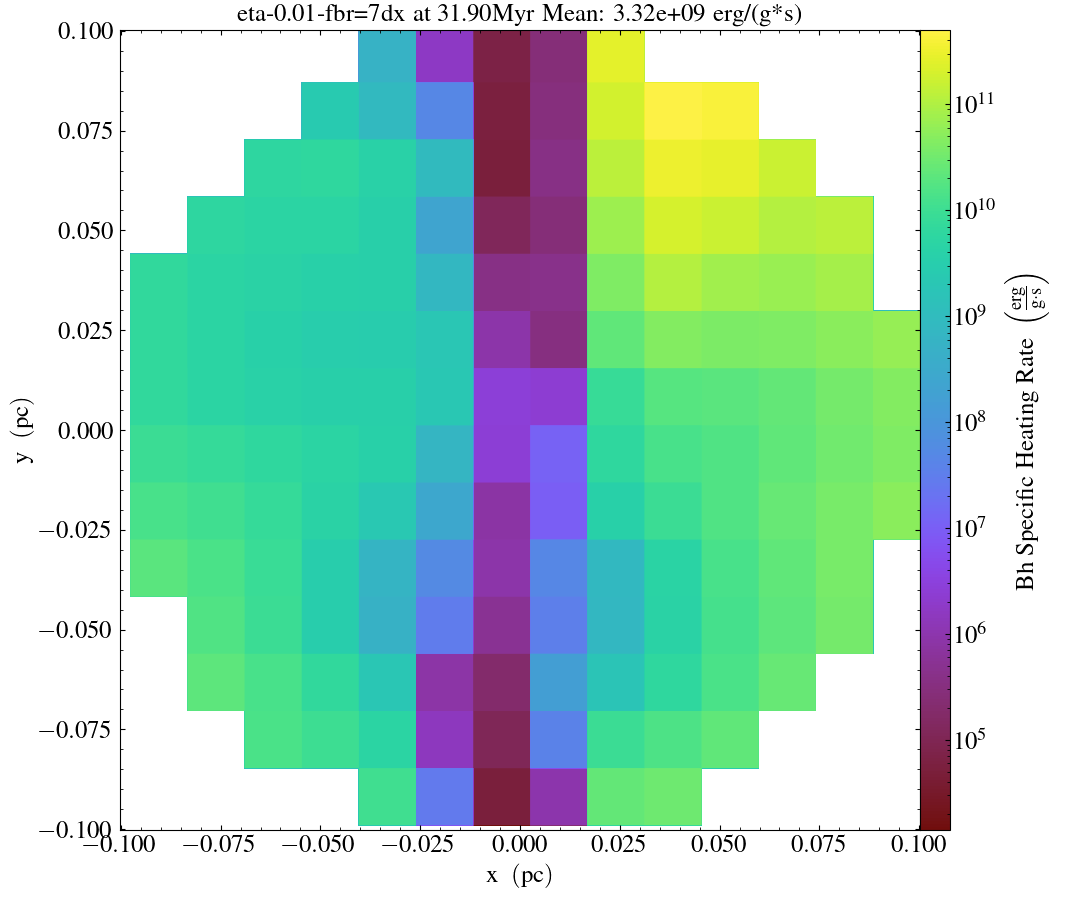

yt : [INFO     ] 2024-10-25 15:28:23,455 Parameters: current_time              = 17.496421395842
yt : [INFO     ] 2024-10-25 15:28:23,456 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-25 15:28:23,458 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-25 15:28:23,459 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-25 15:28:23,460 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-25 15:28:23,461 Parameters: current_redshift          = 22.460874914835
yt : [INFO     ] 2024-10-25 15:28:23,461 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-25 15:28:23,462 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-25 15:28:23,463 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-25 15:28:23,465 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 4115/4115 [00:00<00:00, 5832.05it/s]
yt : [INFO     ] 2024-10-25

ds =  DD0693
r_cells: 10


yt : [INFO     ] 2024-10-25 15:29:20,685 xlim = 0.488054 0.488064
yt : [INFO     ] 2024-10-25 15:29:20,686 ylim = 0.492871 0.492881
yt : [INFO     ] 2024-10-25 15:29:20,691 xlim = 0.488054 0.488064
yt : [INFO     ] 2024-10-25 15:29:20,692 ylim = 0.492871 0.492881
yt : [INFO     ] 2024-10-25 15:29:20,695 Making a fixed resolution buffer of (('gas', 'BH_specific_heating_rate')) 800 by 800


bh_pos: [[0.48805897 0.49287624 0.50825896]] code_length, bh_r: [4.76837158e-06] code_length, mdot: [6.51621353e-08] code_mass/code_time
bh_pos: [[0.48805897 0.49287624 0.50825896]] code_length, bh_r: [4.76837158e-06] code_length, mdot: [6.51621353e-08] code_mass/code_time
bh_pos: [[0.48805897 0.49287624 0.50825896]] code_length, bh_r: [4.76837158e-06] code_length, mdot: [6.51621353e-08] code_mass/code_time
bh_pos: [[0.48805897 0.49287624 0.50825896]] code_length, bh_r: [4.76837158e-06] code_length, mdot: [6.51621353e-08] code_mass/code_time
bh_pos: [[0.48805897 0.49287624 0.50825896]] code_length, bh_r: [4.76837158e-06] code_length, mdot: [6.51621353e-08] code_mass/code_time
bh_pos: [[0.48805897 0.49287624 0.50825896]] code_length, bh_r: [4.76837158e-06] code_length, mdot: [6.51621353e-08] code_mass/code_time
bh_pos: [[0.48805897 0.49287624 0.50825896]] code_length, bh_r: [4.76837158e-06] code_length, mdot: [6.51621353e-08] code_mass/code_time
bh_pos: [[0.48805897 0.49287624 0.5082589


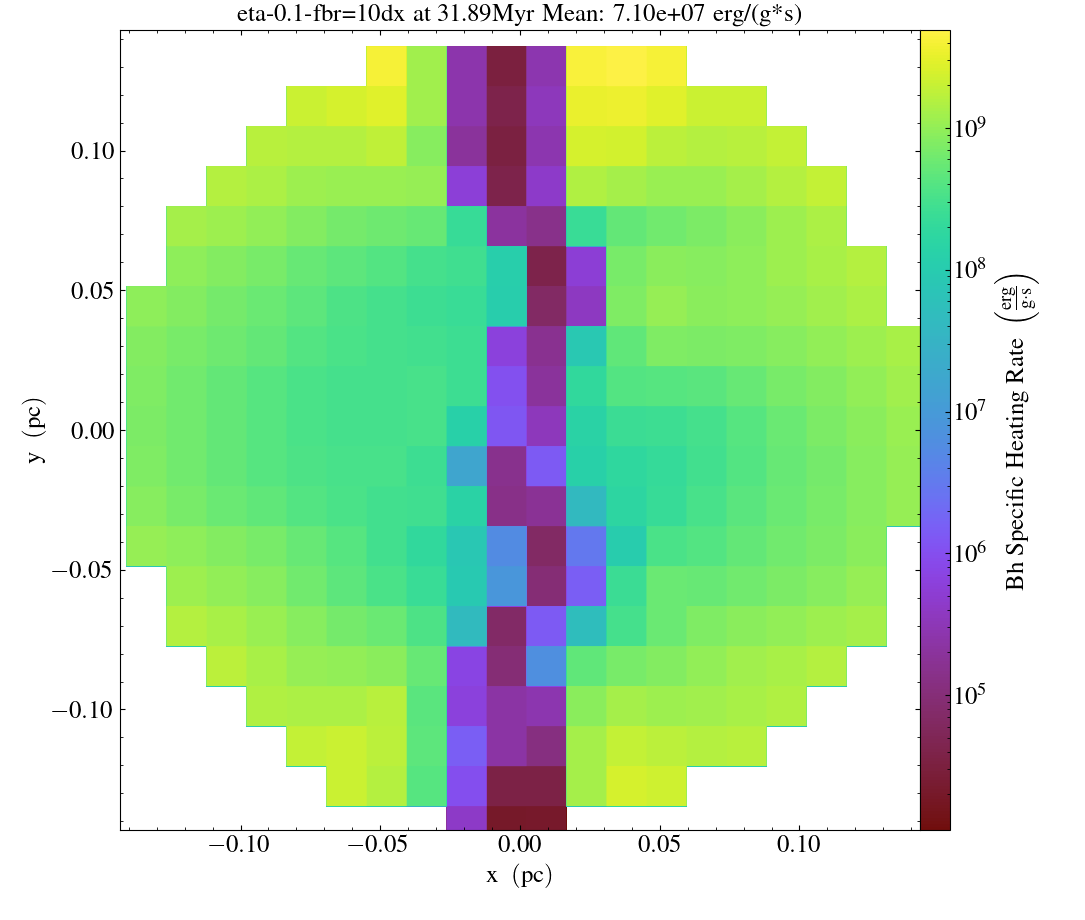

In [53]:
simulations_2 = [
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b01-3-eps-0.001/DD0445/DD0445", "name": "Initial State", "epsilon": 1e-11},
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b01-3-eps-0.0001/DD0653/DD0653", "name": "eps-0.0001-fbr=5dx", "epsilon": 1e-6},
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b01-3-eps-0.001/DD2783/DD2783", "name": "eps-0.001-fbr=5dx", "epsilon": 1e-5},
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b01-3-eta-0.01/fb-radius=10dx/DD0702/DD0702", "name": "eta-0.01-fbr=10dx", "epsilon": 5e-4},
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b01-3-eta-0.01/fb-radius=7dx/DD0704/DD0704", "name": "eta-0.01-fbr=7dx", "epsilon": 5e-4},
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b01-3-eta-0.01/DD0643/DD0643", "name": "eta-0.01-fbr=5dx", "epsilon": 5e-4},
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b01-3-eta-0.1/fb-radius=10dx/DD0693/DD0693", "name": "eta-0.1-fbr=10dx", "epsilon": 5e-3},
]

for sim in simulations_2:
    ds = yt.load(sim["path"])
    ad = ds.all_data()

    # feedback sphere around black hole
    pos = ad["SmartStar", "particle_position"][0]
    pos, mass, age = ss_properties(ds)
    try:
        r_cells = ds.parameters['SmartStarBHThermalFeedbackRadiusinCells']
    except KeyError:
        r_cells = 5
    print(f"r_cells: {r_cells}")
    dx = ds.find_field_values_at_point([("index", "dx")], pos)[0].to('pc')
    sphere = ds.sphere(pos, dx * r_cells)

    bh_prepare_object(sphere, epsilon=sim["epsilon"])

    ds.add_field(("gas", "BH_specific_heating_rate"), function=_bh_specific_heating_rate, sampling_type="local", units="erg/s/g", force_override=True)
    ds.add_field(("gas", "BH_accretion_cooling_time"), function=_bh_accretion_cooling_time, sampling_type="local", units="s", force_override=True)
    ds.add_field(("gas", "BH_accretion_heating_to_cooling_ratio"), function=_bh_accretion_heating_to_cooling_ratio, sampling_type="local", units="", force_override=True)

    p = yt.SlicePlot(ds, "z", [("gas", "BH_specific_heating_rate")],
                        data_source=sphere, center=sphere.center,
                        width=2*sphere.radius.to('pc'))
    #p.set_unit("BH_accretion_cooling_time", "Myr")
    mean_rate = np.mean(sphere[("gas", "BH_specific_heating_rate")])
    E2_specific_heating_rate_means.append({"name": sim["name"], "mean [erg/(g*s)]": mean_rate.d})
    p.annotate_title(f"{sim['name']} at {age[0]/1e6:.2f}Myr Mean: {mean_rate:.2e}")
    p.show()

In [52]:
df = pd.DataFrame(E2_specific_heating_rate_means, columns=["name", "mean [erg/(g*s)]"])
df_sorted = df.sort_values(by="mean [erg/(g*s)]", ascending=True)
df_sorted["mean [erg/(g*s)]"] = df_sorted["mean [erg/(g*s)]"].apply(lambda x: f'{x:.2e}')
df_sorted

,name,mean [erg/(g*s)]
0,Initial State,3.24e+02
5,eta-0.01-fbr=5dx,9.67e+06
6,eta-0.1-fbr=10dx,5.97e+07
7,eta-0.01-fbr=5dx,1.04e+08
2,eps-0.001-fbr=5dx,5.34e+08
1,eps-0.0001-fbr=5dx,1.51e+09
4,eta-0.01-fbr=7dx,6.71e+09
3,eta-0.01-fbr=10dx,7.38e+09


## Event 3

yt : [INFO     ] 2024-10-25 15:02:13,582 Parameters: current_time              = 22.571567263226
yt : [INFO     ] 2024-10-25 15:02:13,584 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-25 15:02:13,586 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-25 15:02:13,587 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-25 15:02:13,589 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-25 15:02:13,590 Parameters: current_redshift          = 18.79683233109
yt : [INFO     ] 2024-10-25 15:02:13,591 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-25 15:02:13,593 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-25 15:02:13,594 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-25 15:02:13,596 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 4167/4167 [00:01<00:00, 3586.46it/s]
yt : [INFO     ] 2024-10-25 

ds =  DD0263
r_cells: 5


yt : [INFO     ] 2024-10-25 15:03:25,062 xlim = 0.499222 0.499224
yt : [INFO     ] 2024-10-25 15:03:25,064 ylim = 0.496339 0.496341
yt : [INFO     ] 2024-10-25 15:03:25,069 xlim = 0.499222 0.499224
yt : [INFO     ] 2024-10-25 15:03:25,071 ylim = 0.496339 0.496341
yt : [INFO     ] 2024-10-25 15:03:25,074 Making a fixed resolution buffer of (('gas', 'BH_specific_heating_rate')) 800 by 800


bh_pos: [[0.49922325 0.49634022 0.49133559]] code_length, bh_r: [1.1920929e-06] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.49922325 0.49634022 0.49133559]] code_length, bh_r: [1.1920929e-06] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.49922325 0.49634022 0.49133559]] code_length, bh_r: [1.1920929e-06] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.49922325 0.49634022 0.49133559]] code_length, bh_r: [1.1920929e-06] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.49922325 0.49634022 0.49133559]] code_length, bh_r: [1.1920929e-06] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.49922325 0.49634022 0.49133559]] code_length, bh_r: [1.1920929e-06] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.49922325 0.49634022 0.49133559]] code_length, bh_r: [1.1920929e-06] code_length, mdot: [1.80793498e-06] code_mass/code_time
bh_pos: [[0.49922325 0.49634022 0.49133559]] cod


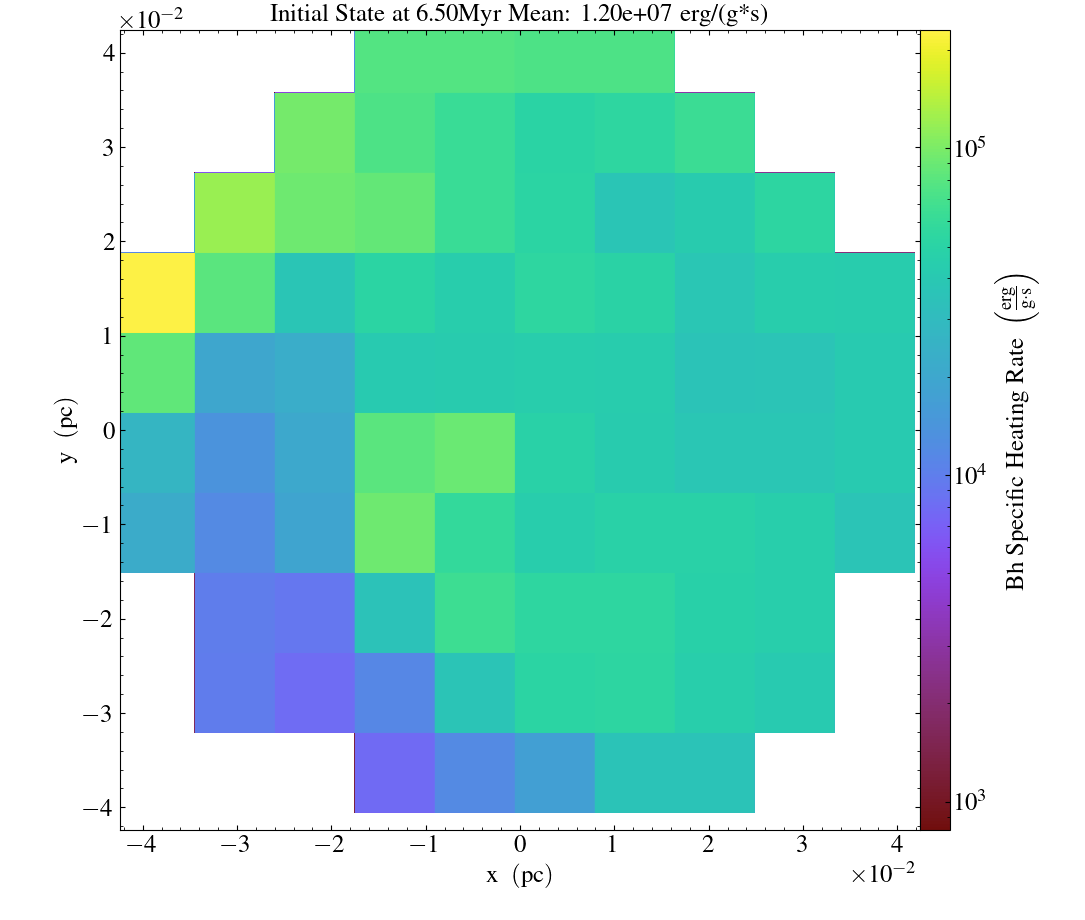

/home/sgordon/micromamba/lib/python3.9/site-packages/yt/sample_data/api.py:149: UserWarning: Storage directory from yt config doesn't exist (currently set to '/does/not/exist'). Current working directory will be used instead.
  warn(


FileNotFoundError: No such file or directory: '/ceph/cephfs/sgordon/pleiades-18-03-24/seed2-bh-only/270msun/thermal-fb/2B.resim.th.b01-eps-0.001/DD0511/DD0511'.

In [47]:
simulations_3 = [
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed2-bh-only/270msun/thermal-fb/2B.resim.th.b01-eps-0.001/DD0263/DD0263", "name": "Initial State", "epsilon": 1e-11},
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed2-bh-only/270msun/thermal-fb/2B.resim.th.b01-eps-0.001/DD0515/DD0515", "name": "eps-0.001-fbr=5dx", "epsilon": 1e-5},
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed2-bh-only/270msun/thermal-fb/2B.resim.th.b01-eps-0.01/DD0511/DD0511", "name": "eps-0.01-fbr=5dx", "epsilon": 5e-4},
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed2-bh-only/270msun/thermal-fb/2B.resim.th.b01-eta-0.01/DD1890/DD1890", "name": "eta-0.01-fbr=5dx", "epsilon": 1e-4},
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed2-bh-only/270msun/thermal-fb/2B.resim.th.b01/DD0900/DD0900", "name": "eta-0.1-fbr=5dx", "epsilon": 0.005},
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed2-bh-only/270msun/thermal-fb/2B.resim.th.b01/2B.resim.th.b01-fb-r-7dx/DD0600/DD0600", "name": "eta-0.1-fbr=7dx", "epsilon": 0.005},
    {"path": "/ceph/cephfs/sgordon/pleiades-18-03-24/seed2-bh-only/270msun/thermal-fb/2B.resim.th.b01-eta-0.1-2/DD0466/DD0466", "name": "eta-0.1-fbr=5dx-2", "epsilon": 0.005}, # 7.1 Myr
]
E3_specific_heating_rate_means = []
for sim in simulations_3:
    ds = yt.load(sim["path"])
    ad = ds.all_data()

    # feedback sphere around black hole
    pos = ad["SmartStar", "particle_position"][0]
    pos, mass, age = ss_properties(ds)
    try:
        r_cells = ds.parameters['SmartStarBHThermalFeedbackRadiusinCells']
    except KeyError:
        r_cells = 5
    print(f"r_cells: {r_cells}")
    dx = ds.find_field_values_at_point([("index", "dx")], pos)[0].to('pc')
    sphere = ds.sphere(pos, dx * r_cells)

    bh_prepare_object(sphere, epsilon=sim["epsilon"])

    ds.add_field(("gas", "BH_specific_heating_rate"), function=_bh_specific_heating_rate, sampling_type="local", units="erg/s/g", force_override=True)
    ds.add_field(("gas", "BH_accretion_cooling_time"), function=_bh_accretion_cooling_time, sampling_type="local", units="s", force_override=True)
    ds.add_field(("gas", "BH_accretion_heating_to_cooling_ratio"), function=_bh_accretion_heating_to_cooling_ratio, sampling_type="local", units="", force_override=True)

    p = yt.SlicePlot(ds, "z", [("gas", "BH_specific_heating_rate")],
                        data_source=sphere, center=sphere.center,
                        width=2*sphere.radius.to('pc'))
    #p.set_unit("BH_accretion_cooling_time", "Myr")
    mean_rate = np.mean(sphere[("gas", "BH_specific_heating_rate")])
    E3_specific_heating_rate_means.append({"name": sim["name"], "mean [erg/(g*s)]": mean_rate.d})
    p.annotate_title(f"{sim['name']} at {age[0]/1e6:.2f}Myr Mean: {mean_rate:.2e}")
    p.show()

In [32]:
df = pd.DataFrame(E3_specific_heating_rate_means, columns=["name", "mean [erg/(g*s)]"])
df_sorted = df.sort_values(by="mean [erg/(g*s)]", ascending=True)
df_sorted["mean [erg/(g*s)]"] = df_sorted["mean [erg/(g*s)]"].apply(lambda x: f'{x:.2e}')
df_sorted

,name,mean [erg/(g*s)]
0,Initial State,1.20e+07
1,eps-0.01-fbr=5dx,1.50e+11
3,eta-0.1-fbr=7dx,3.38e+11
2,eta-0.1-fbr=5dx,2.86e+14


## All

In [89]:
# join the dataframes
df_all = pd.concat([pd.DataFrame(E1_specific_heating_rate_means), pd.DataFrame(E2_specific_heating_rate_means), pd.DataFrame(E3_specific_heating_rate_means)], ignore_index=True)
df_sorted_all = df_all.sort_values(by="mean [erg/(g*s)]", ascending=True)
df_sorted_all["mean [erg/(g*s)]"] = df_sorted_all["mean [erg/(g*s)]"].apply(lambda x: f'{x:.2e}')
df_sorted_all["mean [erg/(g*s)]"] = df_sorted_all["mean [erg/(g*s)]"].apply(lambda x: float(x))
df_sorted_all

,name,mean [erg/(g*s)]
9,eta-0.01-fbr=5dx,9.680000e+06
10,Initial State,1.200000e+07
0,Initial State,1.330000e+08
6,Initial State,3.240000e+08
5,eps-0.001-fbr=5dx,1.070000e+09
8,eta-0.01-fbr=7dx,6.720000e+09
7,eta-0.01-fbr=10dx,7.390000e+09
4,eps-0.001-2-fbr=5dx,8.610000e+09
3,eta-0.1-fbr=10dx,8.410000e+10
11,eps-0.01-fbr=5dx,1.500000e+11


/tmp/ipykernel_200843/78645360.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, len(df_sorted_all["name"]))


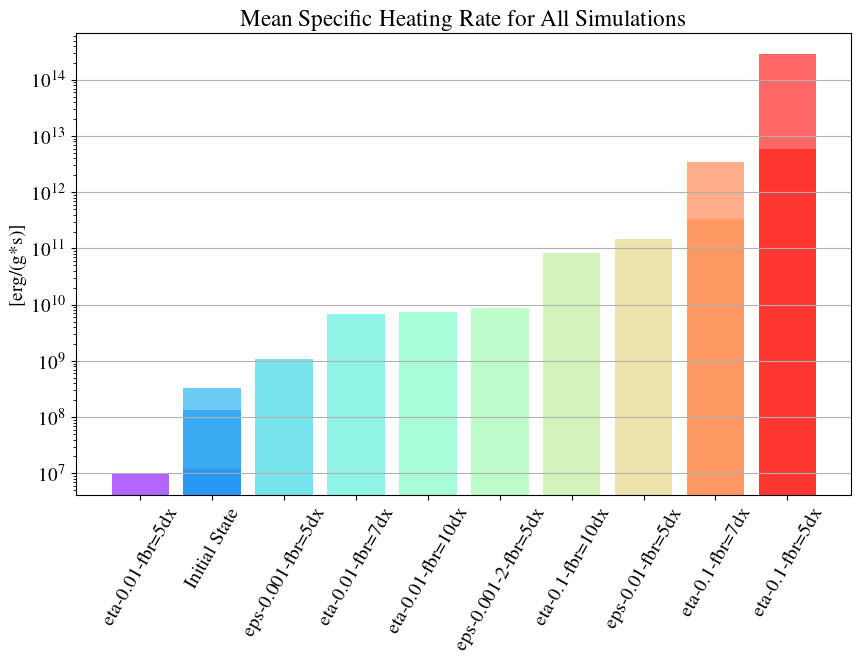

In [97]:
# Plot the mean specific heating rate for all simulations
import matplotlib.cm as cm  # Import colormap module
plt.figure(figsize=(10, 6))
setup_plot_env(fontsize=14)

# Access a colormap from yt (for example, 'viridis' is also available in yt)
cmap = "rainbow"
cmap = cm.get_cmap(cmap, len(df_sorted_all["name"]))
colors = [cmap(i) for i in range(len(df_sorted_all["mean [erg/(g*s)]"]))]

plt.bar(df_sorted_all["name"], df_sorted_all["mean [erg/(g*s)]"], color=colors, alpha=0.6)
#plt.xlabel("Simulation Name")
plt.ylabel("[erg/(g*s)]")
plt.yscale("log")
plt.title("Mean Specific Heating Rate for All Simulations")
plt.xticks(rotation=60)
plt.grid(axis='y')
plt.show()

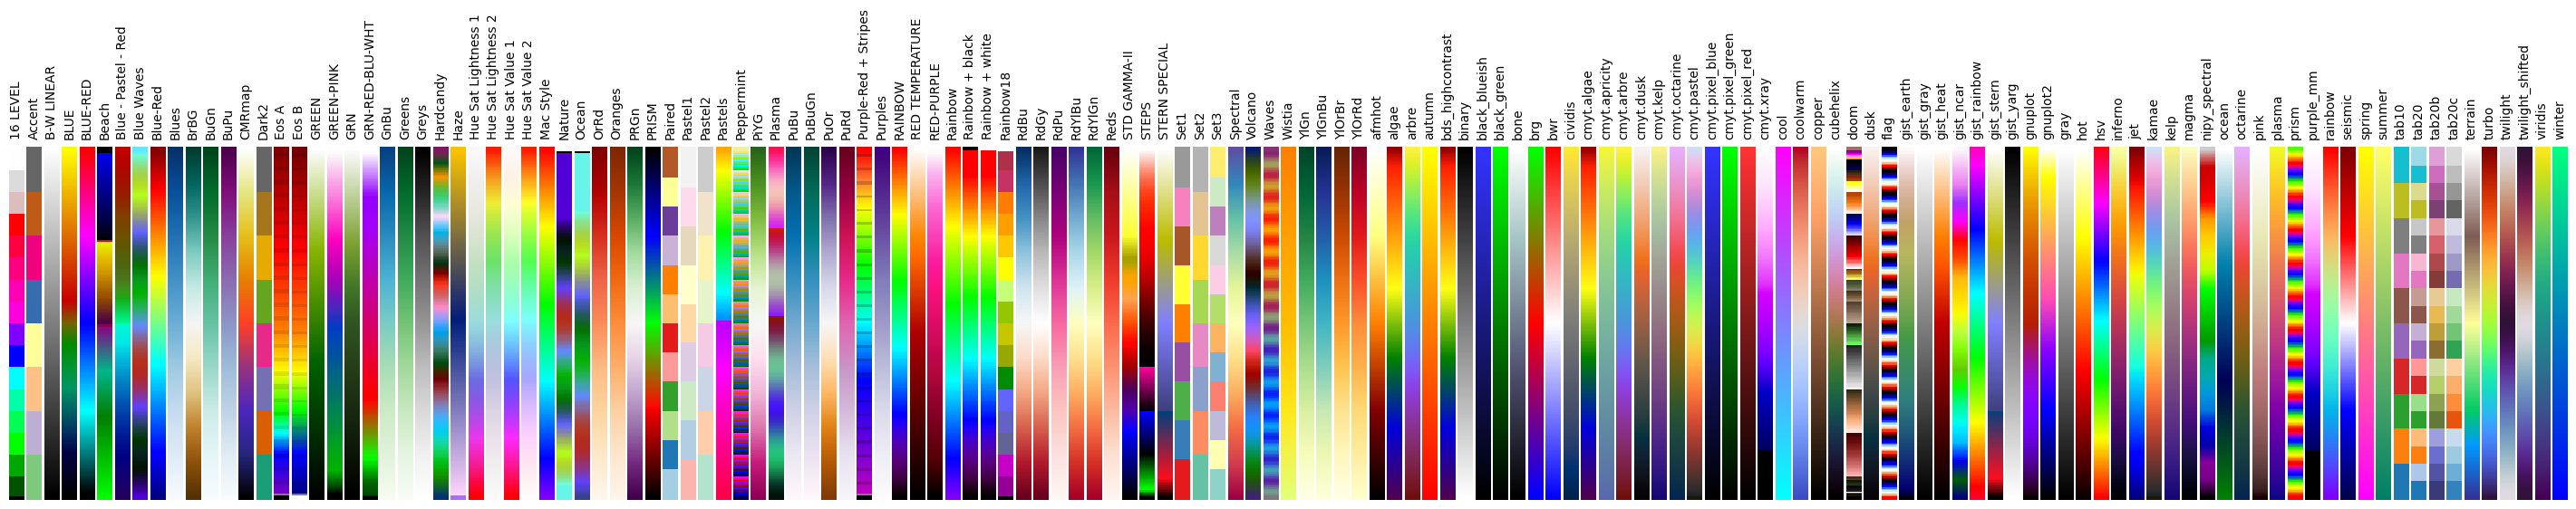

In [58]:
yt.show_colormaps()

In [88]:

df_sorted_all

9     9.680000e+06
10    1.200000e+07
0     1.330000e+08
6     3.240000e+08
5     1.070000e+09
8     6.720000e+09
7     7.390000e+09
4     8.610000e+09
3     8.410000e+10
11    1.500000e+11
13    3.380000e+11
2     3.430000e+12
1     5.800000e+12
12    2.860000e+14
Name: mean [erg/(g*s)], dtype: float64

## Scatter of Specific Heating Rate vs Mass Enclosed

In [20]:
import pandas as pd
# import matplotlib.pyplot as plt
# import yt
# import numpy as np

In [27]:
# Define a function to calculate the relative mass enclosed
# Load the CSV data
csv_file = "specific_heating_rates.csv" 
data = pd.read_csv(csv_file)
df = pd.DataFrame(data)

def calculate_relative_mass(df):
    # Find the mass enclosed for the "Initial State"
    initial_state_mass = df.loc[df['simulation_name'] == 'Initial State', 'mass_enclosed_msun'].values[0]
    print(f"Initial State mass: {initial_state_mass:.2e} Msun")
    # Calculate relative mass for all entries
    df['relative_mass_enclosed'] = df['mass_enclosed_msun'] / initial_state_mass
    return df

# Apply this function to each event
df = df.groupby('event').apply(calculate_relative_mass)


Initial State mass: 1.03e+03 Msun
Initial State mass: 5.38e+03 Msun
Initial State mass: 3.01e+02 Msun
Initial State mass: 2.00e+02 Msun


In [28]:
# Reset the index to remove ambiguity
data_reset = df.reset_index(drop=True)

# Select only the numeric columns for averaging
numeric_columns = ['age_myr', 'bh_specific_heating_rate', 'mass_enclosed_msun', 'relative_mass_enclosed']

# Group by 'event' and 'simulation_name' and calculate the mean only on the numeric columns
reduced_df = data_reset.groupby(['event', 'simulation_name'])[numeric_columns].mean().reset_index()
# Remove all rows where the 'simulation_name' is 'Initial State'
reduced_df = reduced_df[reduced_df['simulation_name'] != 'Initial State']

# Now group by 'event' and 'simulation_name' and calculate the mean on the numeric columns
reduced_df = reduced_df.groupby(['event', 'simulation_name'])[numeric_columns].mean().reset_index()

reduced_df


,event,simulation_name,age_myr,bh_specific_heating_rate,mass_enclosed_msun,relative_mass_enclosed
0,1,eps-0.001-fbr=5dx,2.700456,9.423907e+09,812.914020,0.785852
1,1,eps-0.001-fbr=5dx-2,2.883565,5.090041e+09,558.528178,0.539934
2,1,eta-0.1-fbr=10dx,2.813299,4.179884e+12,376.965945,0.364416
3,1,eta-0.1-fbr=5dx,2.713299,8.361992e+12,348.411401,0.336813
4,1,eta-0.1-fbr=5dx-2,2.889299,9.086323e+11,395.070841,0.381919
5,1,eta-0.1-fbr=7dx,2.713299,3.994150e+12,246.422878,0.238219
6,2,eps-0.0001-fbr=5dx,31.914253,6.914662e+08,5324.380465,0.989368
7,2,eps-0.001-fbr=5dx,31.913363,2.188066e+08,5697.661095,1.058730
8,2,eta-0.01-fbr=10dx,31.915483,5.186783e+10,5234.953607,0.972751
9,2,eta-0.01-fbr=5dx,31.854583,4.214018e+08,2365.769606,0.439604


In [63]:
rename_map = {
    "eps-0.001-fbr=5dx": r"$\epsilon_f0.001$-5dx",
    "eps-0.001-2-fbr=5dx": r"$\epsilon_f0.001$-5dx-2",
    "eta-0.1-fbr=10dx": r"$\epsilon_r0.1$-10dx",
    "eta-0.1-fbr=5dx": r"$\epsilon_r0.1$-5dx",
    "eta-0.1-fbr=5dx-2": r"$\epsilon_r0.1$-5dx-2",
    "eta-0.1-fbr=7dx": r"$\epsilon_r0.1$-7dx",
    "eps-0.0001-fbr=5dx": r"$\epsilon_f0.0001$-5dx",
    "eps-0.001-fbr=5dx": r"$\epsilon_f0.001$-5dx",
    "eps-0.01-fbr=5dx": r"$\epsilon_f0.01$-5dx",
    "eta-0.01-fbr=7dx": r"$\epsilon_r0.01$-7dx",
    "eta-0.01-fbr=10dx": r"$\epsilon_r0.01$-10dx",
    "eps-0.001-fbr=5dx-2": r"$\epsilon_f0.001$-5dx-2",
    "eps-0.01-fbr=5dx": r"$\epsilon_f0.01$-5dx",
    "eta-0.1-fbr=5dx": r"$\epsilon_r0.1$-5dx",
    "eta-0.1-fbr=5dx-2": r"$\epsilon_r0.1$-5dx-2",
    "eta-0.1-fbr=7dx": r"$\epsilon_r0.1$-7dx",
    "eta-0.01-fbr=5dx": r"$\epsilon_r0.01$-5dx",
}
reduced_df['simulation_name'] = reduced_df['simulation_name'].replace(rename_map)

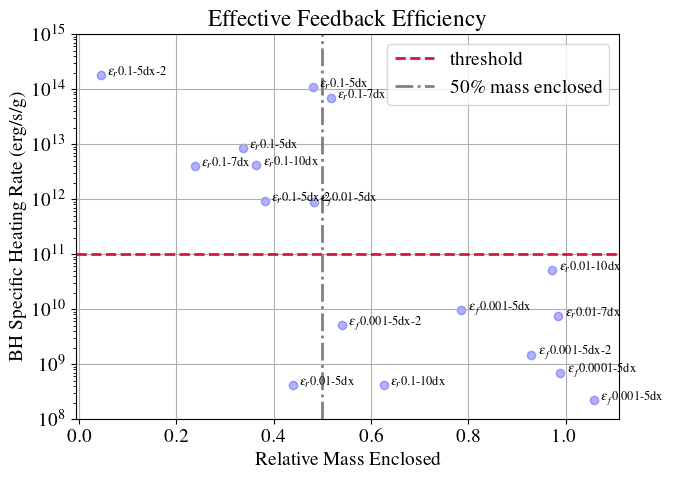

In [64]:
# Plotting
SAVE = True
plt.figure(figsize=(7,5))
setup_plot_env(fontsize=14)
plt.scatter(reduced_df['relative_mass_enclosed'], reduced_df['bh_specific_heating_rate'], color='blue', alpha=0.3)
# Adding labels for each point
for i, row in reduced_df.iterrows():
    if i in [len(reduced_df)-1]:
        continue
    plt.text(row['relative_mass_enclosed']+0.015, row['bh_specific_heating_rate'], row['simulation_name'], fontsize=9, ha='left')
    
plt.title('Effective Feedback Efficiency')
plt.axhline(1e11, color='crimson', linestyle='--', lw=2, label='threshold')
plt.axvline(0.5, color='grey', linestyle='-.', lw=2, label='50\% mass enclosed')
plt.xlabel('Relative Mass Enclosed')
plt.ylabel('BH Specific Heating Rate (erg/s/g)')
plt.ylim(1e8, 1e15)
plt.yscale('log')
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig('plots/effective_feedback_efficiency.png', dpi=300) if SAVE else None
plt.show()

In [74]:
path = "/ceph/cephfs/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b01-3-eta-0.1"
dd_id = "DD0495"
ds = yt.load(f"{path}/{dd_id}/{dd_id}")

yt : [INFO     ] 2024-10-28 16:41:27,816 Parameters: current_time              = 17.475713985631
yt : [INFO     ] 2024-10-28 16:41:27,818 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-28 16:41:27,820 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-28 16:41:27,821 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-28 16:41:27,823 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-28 16:41:27,824 Parameters: current_redshift          = 22.479405474606
yt : [INFO     ] 2024-10-28 16:41:27,825 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-10-28 16:41:27,826 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-10-28 16:41:27,828 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-10-28 16:41:27,829 Parameters: hubble_constant           = 0.71


In [78]:
dd = ds.all_data()
timeindex = dd["SmartStar", "TimeIndex"][0].d
accrate = dd["SmartStar", "AccretionRate"][0][1:int(timeindex+1)].in_units("Msun/yr")
np.mean(accrate)

unyt_quantity(0.00254984, 'Msun/yr')

# Misc

In [187]:
data = sphere
cell_pos = data.ds.arr([data["index", ax] for ax in "xyz"]).T
bh_pos = data.get_field_parameter("bh_centers")
bh_r = data.get_field_parameter("bh_feedback_radii")
mdot = data.get_field_parameter("accretion_rate")
print(f"bh_pos: {bh_pos}, bh_r: {bh_r.to('pc')}, mdot: {mdot.to('Msun/yr')}") # sensible values

bh_pos: [[0.49037163 0.49460398 0.50954984]] code_length, bh_r: [0.01559326] pc, mdot: [0.00114115] Msun/yr


In [213]:
epsilon = 0.001 * 0.01
field_data = data.ds.arr(np.zeros(data["gas", "density"].shape), "erg/s/g")
# loop over each bh and add heating where d < r
for i in range(bh_r.size):
    my_pos = bh_pos[i]
    my_r2 = bh_r[i]**2
    d2 = ((cell_pos - my_pos)**2).sum(axis=1)
    my_mdot = mdot[i]
    my_filter = d2 <= my_r2
    field_data[my_filter] = epsilon * c**2 * my_mdot / data["gas", "cell_mass"] / my_filter.sum()

In [177]:
d2 = ((cell_pos - my_pos)**2).sum(axis=1)
my_filter.sum()

529